# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

Repositorio Github

https://github.com/MaximilianoAlarcon/Acamica_Proyecto_3_Amazon

## **1. Exploración de datos**

**Importamos las librerias**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import spacy
from spacy.lang.es.stop_words import STOP_WORDS
from spacy.lang.es import Spanish
import re
import string

**Carga de datos**

En caso de que las urls no funcionen para cargar los datasets, por favor reemplazarlos por los archivos de este repositorio
https://github.com/MaximilianoAlarcon/Acamica_Proyecto_3_Amazon

In [ ]:
df_train = pd.read_json("https://amazon-reviews-ml.s3-us-west-2.amazonaws.com/json/train/dataset_es_train.json", lines=True)
df_test = pd.read_json("https://amazon-reviews-ml.s3-us-west-2.amazonaws.com/json/test/dataset_es_test.json", lines=True)
df_dev = pd.read_json("https://amazon-reviews-ml.s3-us-west-2.amazonaws.com/json/dev/dataset_es_dev.json", lines=True)

In [ ]:
print("Train:",df_train.shape)
print("Test:",df_test.shape)
print("Dev:",df_dev.shape)

Train: (200000, 8)
Test: (5000, 8)
Dev: (5000, 8)


Definiendo nuevas variables para analizar el texto (longitud del texto)

In [ ]:
def longitud_texto(df):
    df['text_length'] = df['review_body'].apply(len)

In [ ]:
lista_df = [df_dev,df_test,df_train]
for i in lista_df:
    longitud_texto(i)

**Inspección de datos**

Vemos como están conformados los datos, qué información contienen y cómo podemos interpretarlos.

In [ ]:
df_train.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,text_length
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics,94
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics,140
2,es_0811721,product_es_0474543,reviewer_es_0929213,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,es,drugstore,117
3,es_0359921,product_es_0656090,reviewer_es_0224702,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,es,wireless,332
4,es_0068940,product_es_0662544,reviewer_es_0224827,1,Llega tarde y co la talla equivocada,Devuelto,es,shoes,36


In [ ]:
df_test.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,text_length
0,es_0038754,product_es_0113523,reviewer_es_0580071,1,no me llego el articulo me lo mando por correo...,no me llego,es,wireless,104
1,es_0748979,product_es_0017036,reviewer_es_0819733,1,"la mensajería horrible, no compro mas",amazon sigue sin cumplir en las entregas,es,home,37
2,es_0411746,product_es_0138642,reviewer_es_0508607,1,Estoy muy decepcionado con el vendedor ya que ...,ESTAFA EN EL ENVÍO,es,toy,232
3,es_0786686,product_es_0170887,reviewer_es_0491157,1,Mi valoración no es sobre el producto sino sob...,Estafa de Amazon,es,home,473
4,es_0429700,product_es_0710642,reviewer_es_0008745,1,Pues tenía interés en este libro y probé la ve...,No conseguí pasar de la portada en Kindle,es,digital_ebook_purchase,229


In [ ]:
df_dev.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,text_length
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless,68
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel,41
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports,170
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement,308
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty,42


Las columnas que sera de utilidad para el objetivo del proyecto son: review_body, review_title y stars

**Revisamos si hay valores faltantes**

In [ ]:
print("Valores faltantes en df_train")
print(df_train.isnull().sum())
print("="*32)
print("Valores faltantes en df_test")
print(df_test.isnull().sum())
print("="*32)
print("Valores faltantes en df_dev")
print(df_dev.isnull().sum())

Valores faltantes en df_train
review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
text_length         0
dtype: int64
Valores faltantes en df_test
review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
text_length         0
dtype: int64
Valores faltantes en df_dev
review_id           0
product_id          0
reviewer_id         0
stars               0
review_body         0
review_title        0
language            0
product_category    0
text_length         0
dtype: int64


No hay datos faltantes

**¿Cuál es el promedio de estrellas de las diferentes categorías?**

In [ ]:
df_train.groupby('product_category')['stars'].describe()

,count,mean,std,min,25%,50%,75%,max
product_category,,,,,,,,
apparel,5737.0,2.866829,1.387221,1.0,2.0,3.0,4.0,5.0
automotive,7143.0,2.950721,1.406303,1.0,2.0,3.0,4.0,5.0
baby_product,4881.0,3.089326,1.385600,1.0,2.0,3.0,4.0,5.0
beauty,7337.0,2.935805,1.414347,1.0,2.0,3.0,4.0,5.0
book,5264.0,3.399316,1.393413,1.0,2.0,4.0,5.0,5.0
camera,3029.0,3.109277,1.398578,1.0,2.0,3.0,4.0,5.0
digital_ebook_purchase,1843.0,3.357027,1.282784,1.0,2.0,3.0,4.0,5.0
drugstore,5513.0,3.010521,1.430628,1.0,2.0,3.0,4.0,5.0
electronics,10385.0,2.887626,1.434022,1.0,2.0,3.0,4.0,5.0


**Promedio de estrellas por categoria**

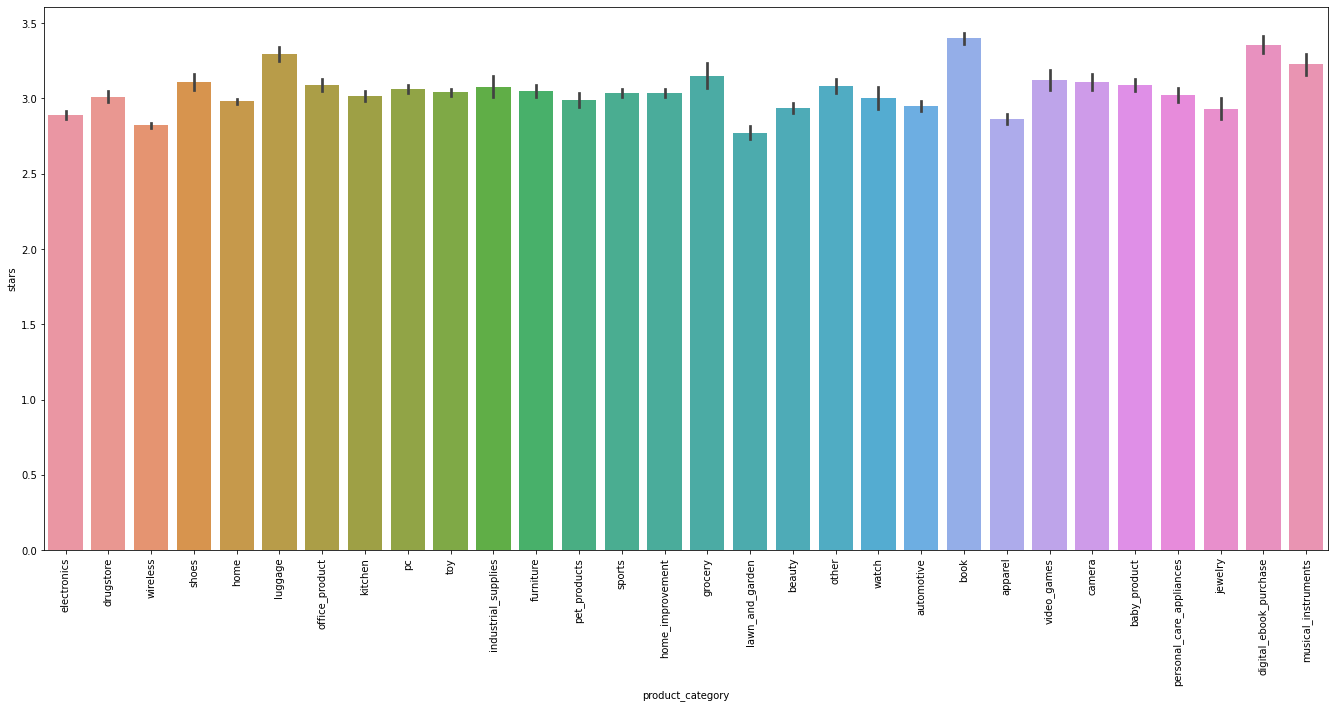

In [ ]:
plt.figure(figsize=(23,10))
plt.xticks(rotation = 90)
sns.barplot(data = df_train, x = 'product_category', y = 'stars')

La distribución de estrellas se encuentra bastante balanceada a través de las categorías.

**¿Cuál es el promedio de cantidad de texto según la categoría?**

In [ ]:
df_train.groupby('product_category')['text_length'].describe()

,count,mean,std,min,25%,50%,75%,max
product_category,,,,,,,,
apparel,5737.0,124.834060,96.628267,17.0,61.00,109.0,153.0,1462.0
automotive,7143.0,137.067199,119.151216,20.0,60.00,110.0,169.0,1385.0
baby_product,4881.0,152.572014,121.168878,19.0,74.00,123.0,195.0,1954.0
beauty,7337.0,144.975467,123.298466,19.0,67.00,117.0,179.0,1981.0
book,5264.0,137.806801,116.898618,19.0,59.00,114.0,172.0,1714.0
camera,3029.0,180.597227,154.522068,20.0,82.00,137.0,224.0,1587.0
digital_ebook_purchase,1843.0,164.441671,122.192908,19.0,93.00,137.0,203.0,1161.0
drugstore,5513.0,143.368583,121.427461,20.0,64.00,116.0,178.0,1971.0
electronics,10385.0,169.193548,153.586144,19.0,75.00,128.0,207.0,2356.0


El promedio parece constante pero hay mucha variabilidad reflejada en la desviacion estandar

**Promedios de la longitud de los textos agrupado por categorias**

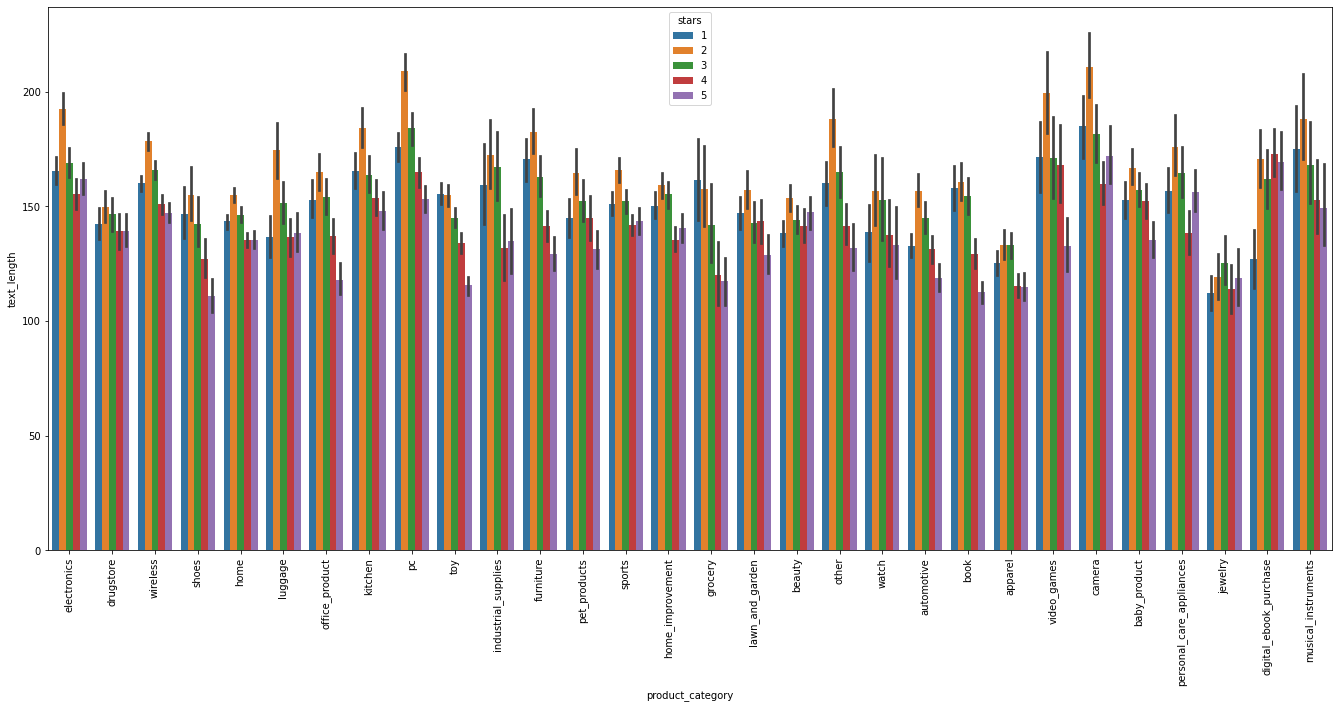

In [ ]:
plt.figure(figsize=(23,10))
plt.xticks(rotation = 90)
sns.barplot(data = df_train, x = 'product_category', y = 'text_length', hue = 'stars')

El promedio se mantiene constante entre las categorías, pero la desviación estandar es muy alta para todos, lo que significa que tenemos mucha variabilidad en la cantidad de texto. Por otra parte, el gráfico parece indicar que la gente escribe más cuando puntúa con 2 estrellas, repitiendose la misma tendencia en todas las categorías. Ocurre lo opuesto cuando la opinión sobre el producto es muy buena y se le asigna 5 estrellas.
Esto significa que hay un patron favorable para identificar las reviews de muy pocas estrellas con las reviews de muchas estrellas

**Histogramas de longitudes de texto**

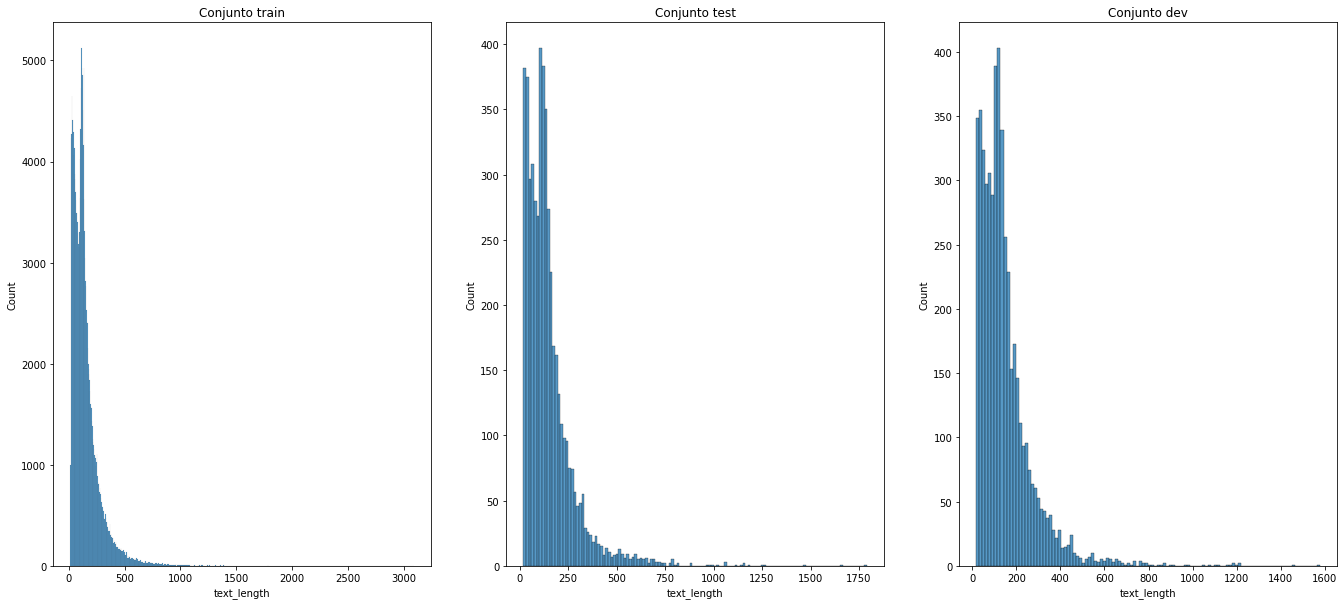

In [ ]:
f = plt.figure(figsize=(23,10))

ax = f.add_subplot(131)
ax.set_title("Conjunto train")
sns.histplot(df_train.text_length, ax=ax)
ax1 = f.add_subplot(132)
ax1.set_title("Conjunto test")
sns.histplot(df_test.text_length, ax=ax1)
ax2 = f.add_subplot(133)
ax2.set_title("Conjunto dev")
sns.histplot(df_dev.text_length, ax=ax2)

Segun los graficos, la mayoria de personas no escribe mas de 500 caracteres

**¿Hay alguna relación entre el largo de texto y la cantidad de estrellas?**

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


(0.0, 1000.0)

<Figure size 1656x720 with 0 Axes>

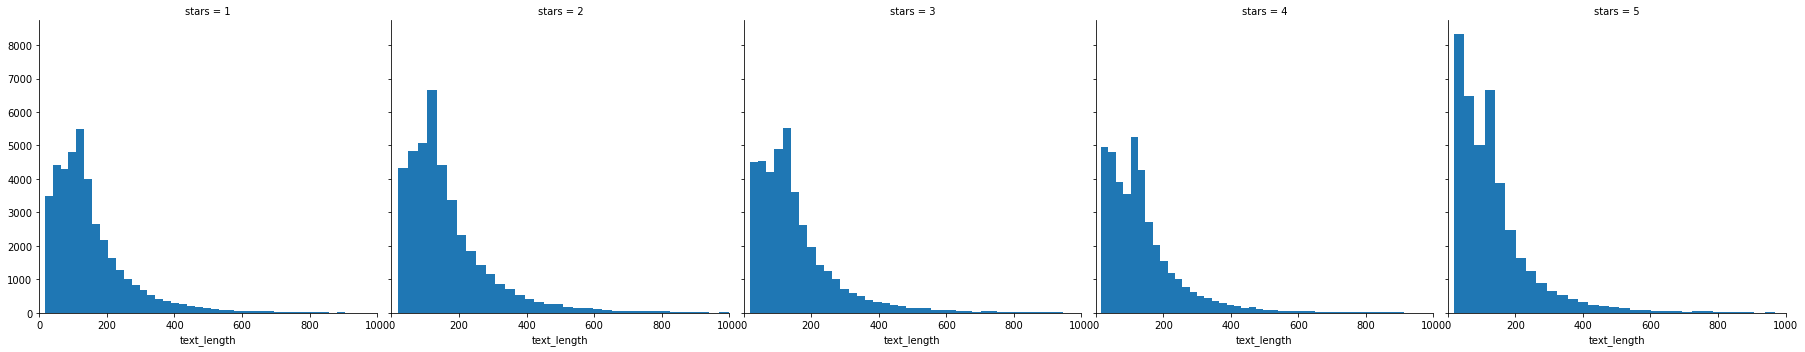

In [ ]:
plt.figure(figsize=(23,10))
g = sns.FacetGrid(df_train, col = 'stars', size=5)
g.map(plt.hist,'text_length', bins = 100)
plt.xlim(0,1000)

Volvemos a notar que la gente suele escribir menos cuando se trata de un excelente producto

**Distribución de reseñas por estrellas**

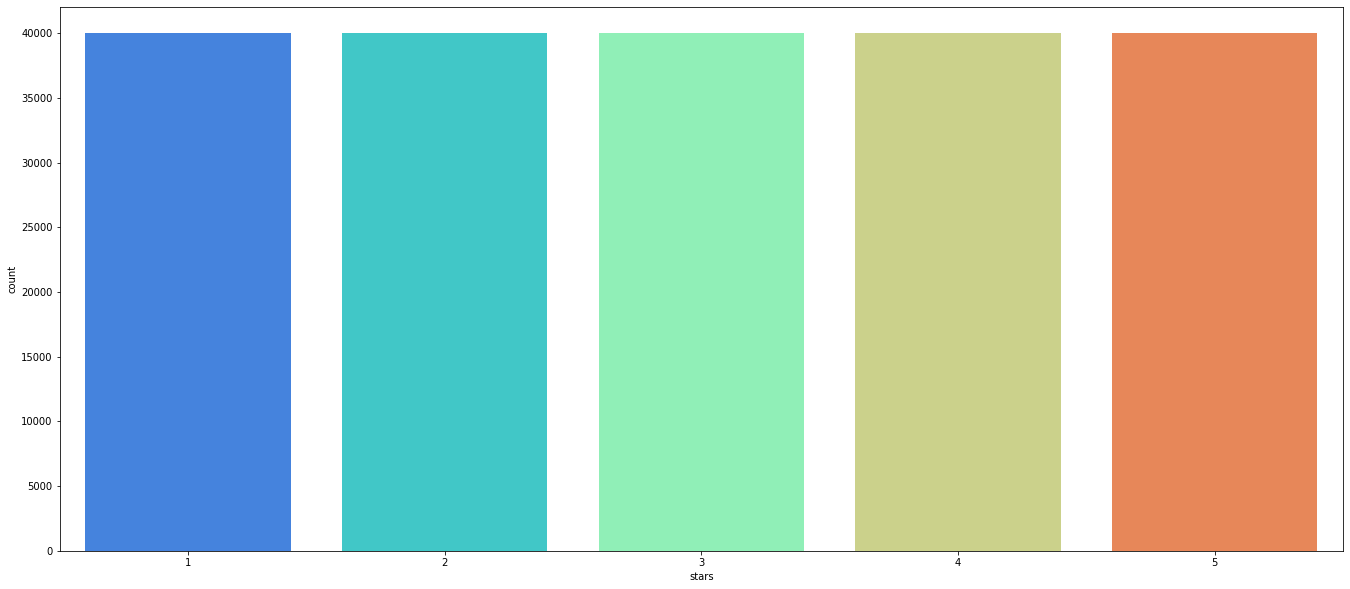

In [ ]:
plt.figure(figsize=(23,10))
sns.countplot(x = 'stars', data = df_train, palette = 'rainbow')

La distribución de reseñas se encuentra balanceada e igual representada para todas las estrellas. Esto se repite para todos los datasets.

**Cantidad de reseñas por comprador**

Vamos a ver si hay algún dato útil o anomalía en la gente que compró mucho

In [ ]:
top_reviewers = df_train['reviewer_id'].value_counts().reset_index(name = 'frequency')
top_reviewers.rename(columns = {'index' : 'reviewer_id'}, inplace=True)
top_reviewers

,reviewer_id,frequency
0,reviewer_es_0431022,7
1,reviewer_es_0437514,7
2,reviewer_es_0588051,7
3,reviewer_es_0659252,6
4,reviewer_es_0424425,6
...,...,...
179071,reviewer_es_0583858,1
179072,reviewer_es_0723329,1
179073,reviewer_es_0689621,1
179074,reviewer_es_0933897,1


In [ ]:
df_train[df_train['reviewer_id'] == 'reviewer_es_0431022']

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,text_length
9219,es_0555103,product_es_0633037,reviewer_es_0431022,1,"Mala elección, talla super pequeño, no lo devo...",no me gusto nada,es,apparel,116
15119,es_0043301,product_es_0918078,reviewer_es_0431022,1,"Lo tuve que devolver, se veía muy endeble y no...",endeble,es,electronics,90
72673,es_0364344,product_es_0065839,reviewer_es_0431022,2,"Se rompió a la primera caída, creo q no son mu...",No lo recomiendo,es,wireless,81
94225,es_0969476,product_es_0466804,reviewer_es_0431022,3,"Colores bonitos, tacto agradable, es suficient...",buena compra,es,apparel,218
154303,es_0419561,product_es_0159509,reviewer_es_0431022,4,"A mi hija le encanto, viene el hada con el cie...",muy bonita,es,toy,102
168351,es_0547249,product_es_0226318,reviewer_es_0431022,5,"Preciosa, de acabados buenos, cose de maravill...",Amor puro,es,home,162
169020,es_0279159,product_es_0499936,reviewer_es_0431022,5,"Resistente, bonita, de buena calidad la recomi...",Muy buena,es,wireless,50


**Grafico de barras que muestra la cantidad de compradores por frecuencia**

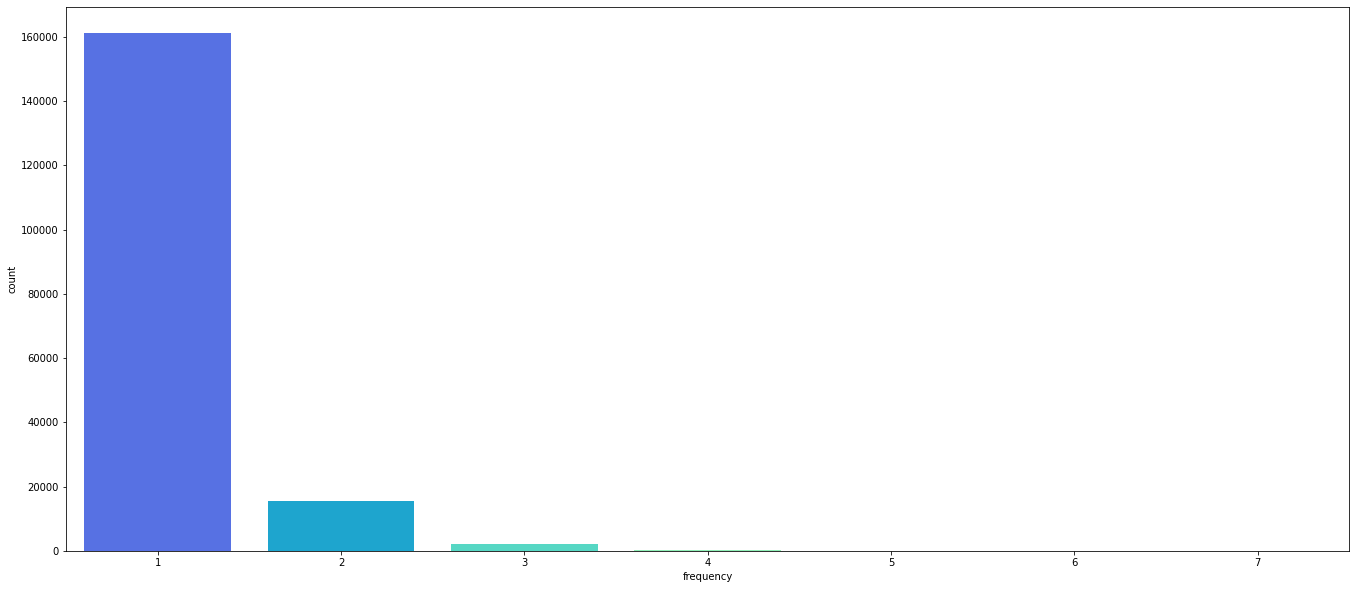

In [ ]:
plt.figure(figsize=(23,10))
sns.countplot(x = 'frequency', data = top_reviewers, palette = 'rainbow')

La mayoria de personas compran una sola vez

**Cantidad de reseñas por producto**

Veremos si hay productos que tuvieron más reseñas que otros

In [ ]:
top_products = df_train['product_id'].value_counts().reset_index(name = 'frequency')
top_products.rename(columns = {'index' : 'product_id'}, inplace=True)
top_products

,product_id,frequency
0,product_es_0261843,8
1,product_es_0086672,7
2,product_es_0523350,7
3,product_es_0087077,7
4,product_es_0741712,7
...,...,...
150933,product_es_0448499,1
150934,product_es_0354145,1
150935,product_es_0255170,1
150936,product_es_0551716,1


In [ ]:
df_train[df_train['product_id'] == 'product_es_0261843']

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category,text_length
11612,es_0233364,product_es_0261843,reviewer_es_0855637,1,No son las canicas de la foto. Son pequeñas y ...,Decepcion,es,toy,66
27746,es_0015129,product_es_0261843,reviewer_es_0782745,1,"El producto aún no ha llegado, tenía que llega...",Estafa,es,toy,111
38929,es_0900151,product_es_0261843,reviewer_es_0634470,1,"Una pena, las canicas son muy cutres, lo único...",Canicas todo a 100,es,toy,67
67287,es_0953681,product_es_0261843,reviewer_es_0978294,2,Son caras y vienen muchas repetidas y ROTAS. L...,Rotas representante y caras. Vete al chino que...,es,toy,115
95799,es_0529308,product_es_0261843,reviewer_es_0981219,3,"Han venido unas pocas rotas, como son tantas n...",Algunas rotas,es,toy,115
124428,es_0101224,product_es_0261843,reviewer_es_0948003,4,Ha sido un regalo para un niño de 6 años y le ...,Bueno,es,toy,54
136414,es_0582312,product_es_0261843,reviewer_es_0000856,4,Buen producto...pero se ve que se había caído ...,Un juguete retro muy logrado.,es,toy,151
156144,es_0361862,product_es_0261843,reviewer_es_0978422,4,Excelente producto. Ideal para regalo a los má...,Excelente presentación,es,toy,89


**Grafico de barras que muestra la cantidad de productos por frecuencia de reseña**

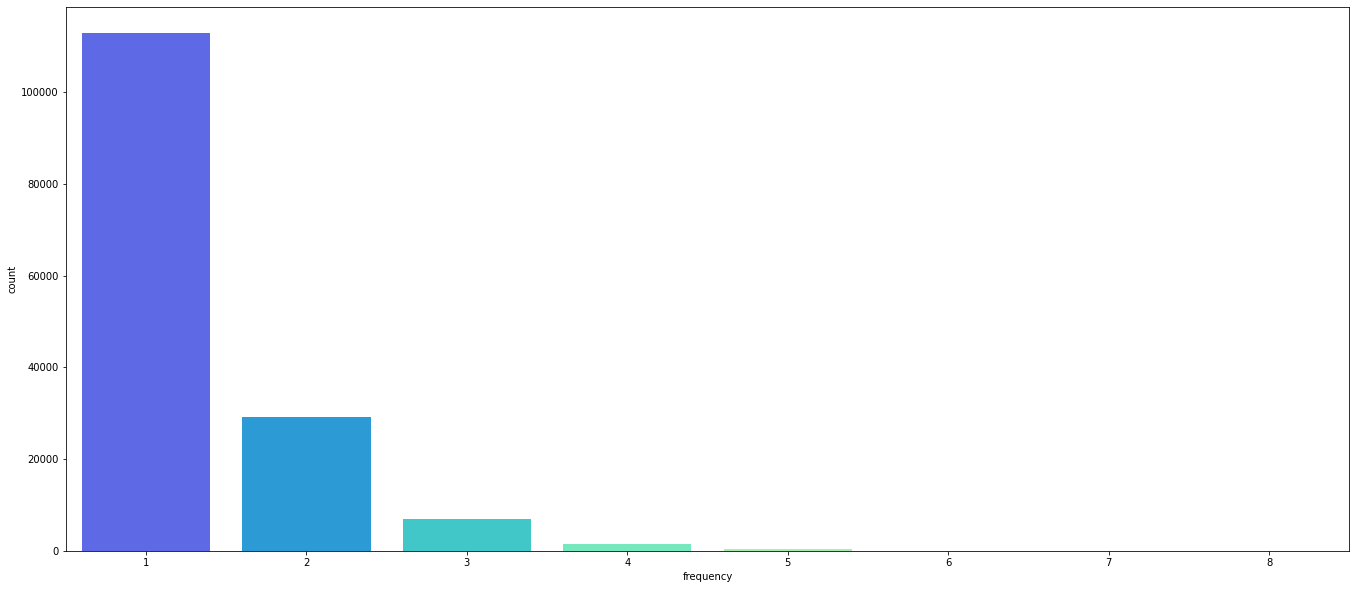

In [ ]:
plt.figure(figsize=(23,10))
sns.countplot(x = 'frequency', data = top_products, palette = 'rainbow')

### Conclusiones
* La variable objetivo (stars) esta balanceada
* Hay indicios para predecir malas y buenas reviews, aunque hay confusion entre las reviews regulares
* El conjunto de entrenamiento esta en condiciones para el siguiente paso

Despues del preprocesamiento voy a hacer graficos de las palabras mas frecuentes por numero de estrellas

## **2. Procesamiento de texto** 

In [ ]:
df_train.drop(labels=['review_id', 'product_id', 'reviewer_id', 'language', 'product_category'], axis =1, inplace=True)
df_test.drop(labels=['review_id', 'product_id', 'reviewer_id', 'language', 'product_category'], axis =1, inplace=True)
df_dev.drop(labels=['review_id', 'product_id', 'reviewer_id', 'language', 'product_category'], axis =1, inplace=True)

print("Train:",df_train.shape)
print("Test:",df_test.shape)
print("Dev:",df_dev.shape)

Train: (200000, 4)
Test: (5000, 4)
Dev: (5000, 4)


Voy a concatenar los titulos y cuerpos de las reviews

In [ ]:
for d in [df_train, df_test, df_dev]:
  d['review_title_body']  = d['review_title']+' '+d['review_body']

Al principio parece que los emojis podrian ayudar en la clasificacion pero hay textos donde hay emojis de carita feliz y carita enojada, por lo que llevaria a una confusion. Por lo tanto voy a enfocarme en utilizar las palabras

In [ ]:
for d in [df_train, df_test, df_dev]:
  d['review_title_body'] = d['review_title_body'].str.replace('[^\w\s#@/:%.,_-]', '', flags=re.UNICODE)

Voy a poner todas las palabras en minusculas para que al momento de vectorizar las palabras no haya problemas de redundancia

In [ ]:
for d in [df_train, df_test, df_dev]:
  d['review_title_body'] = d['review_title_body'].str.lower()

Voy a eliminar los caracteres irrelevantes en los textos y mantener los mas relevantes, para eso, uso una expresion regular que contiene las letras del alfabeto español

In [ ]:
for d in [df_train, df_test, df_dev]:
  d['review_title_body'].replace('[^A-Za-záéíóúÁÉÍÓÚÑñü]',' ', regex=True, inplace=True)

Asi es como queda:

In [ ]:
display(df_train)

,stars,review_body,review_title,text_length,review_title_body
0,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,94,television nevir nada bueno se me fue ka panta...
1,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,140,dinero tirado a la basura con esta compra horr...
2,1,Te obligan a comprar dos unidades y te llega s...,solo llega una unidad cuando te obligan a comp...,117,solo llega una unidad cuando te obligan a comp...
3,1,"No entro en descalificar al vendedor, solo pue...",PRODUCTO NO RECIBIDO.,332,producto no recibido no entro en descalificar...
4,1,Llega tarde y co la talla equivocada,Devuelto,36,devuelto llega tarde y co la talla equivocada
...,...,...,...,...,...
199995,5,Mando funciona perfectamente y cumple con toda...,Tal y como se describe,142,tal y como se describe mando funciona perfecta...
199996,5,"Compré la batería con cierta reticencia, pero ...",Funciona perfectamente,175,funciona perfectamente compré la batería con c...
199997,5,Buena calidad. Satisfecha con la compra.,Buena calidad.,40,buena calidad buena calidad satisfecha con l...
199998,5,Perfecto para el cumple de mi hijo,Recomendado,34,recomendado perfecto para el cumple de mi hijo


Funcion patra llevar a minusculas, eliminar stopwords, puntuaciones y lemmatizar

In [ ]:
#Función patra llevar a minúsculas, eliminar stopwords, puntuaciones y lemmatizar

#nlp = spacy.load('es_core_news_lg')

def normalizar(texto, en_minuscula, remover_stowords):
    
    puntuaciones = string.punctuation
    stops = spacy.lang.es.stop_words.STOP_WORDS
    non_stops = ['bueno','buena'] #Palabras que ayudarian bastante
    otros = ['y', 'e', 'a', 'o', 'para', 'pare', 'paro', 'como', 'q','..','...','....', '.....','.......', '...........','¡','¿']

    if en_minuscula:
        texto = texto.lower()
    texto = nlp(texto)
    listalemm = list()
    for palabra in texto:
        if palabra.text not in non_stops:
            if not remover_stowords or (remover_stowords and palabra.text not in stops): 
                if palabra.text not in puntuaciones:
                    if palabra.text not in otros:
                        lemma = palabra.lemma_.strip()
                        listalemm.append(lemma)
        elif palabra.text in non_stops:
            lemma = palabra.lemma_.strip()
            listalemm.append(lemma)
            
    return " ".join(listalemm)

Voy a aplicar la funcion anterior a todos los datasets, pero en la entrega del proyecto voy a cargar los resultados por url porque colab necesita instalar una dependencia de spacy y reiniciar el entorno, el notebook debe ejecutarse sin errores.

En caso de que las urls no funcionen para cargar los datasets, por favor reemplazarlos por los archivos de este repositorio
https://github.com/MaximilianoAlarcon/Acamica_Proyecto_3_Amazon

In [ ]:
#df_train['review_title_body_lemm'] = df_train['review_title_body'].apply(normalizar, en_minuscula=True, remover_stowords=True)
df_train = pd.read_json("https://softpetsas.com/amazon_train_lemm.json")
df_train[["review_title_body","review_title_body_lemm"]].head()

,review_title_body,review_title_body_lemm
0,television nevir nada bueno se me fue ka panta...,television nevir bueno ka pantalla mes recibi...
1,dinero tirado a la basura con esta compra horr...,dinero tirado basura compra horrible tener co...
2,solo llega una unidad cuando te obligan a comp...,llegar unidad obligar comprar obligar comprar ...
3,producto no recibido no entro en descalificar...,producto recibir entrar descalificar vendedor...
4,devuelto llega tarde y co la talla equivocada,devuelto llegar co talla equivocado


In [ ]:
#df_test['review_title_body_lemm'] = df_test['review_title_body'].apply(normalizar, en_minuscula=True, remover_stowords=True)
df_test = pd.read_json("https://softpetsas.com/amazon_test_lemm.json")
df_test[["review_title_body","review_title_body_lemm"]].head()

,review_title_body,review_title_body_lemm
0,no me llego no me llego el articulo me lo mand...,llegar llegar articulo mandar correo normal se...
1,amazon sigue sin cumplir en las entregas la me...,amazon cumplir entrega mensajería horrible co...
2,estafa en el envío estoy muy decepcionado con ...,estafa envío decepcionado vendedor pedido cump...
3,estafa de amazon mi valoración no es sobre el ...,estafa amazon valoración producto amazon ofre...
4,no conseguí pasar de la portada en kindle pues...,conseguir pasar portada kindle interés libro p...


In [ ]:
#df_dev['review_title_body_lemm'] = df_dev['review_title_body'].apply(normalizar, en_minuscula=True, remover_stowords=True)
df_dev = pd.read_json("https://softpetsas.com/amazon_dev_lemm.json")
df_dev[["review_title_body","review_title_body_lemm"]].head()

,review_title_body,review_title_body_lemm
0,mala compra malisimo muy grande demasiado apa...,malo compra malisimo grande aparatoso protect...
1,no lo he recibido no he recibido el pedido no ...,recibir recibir pedido devolución
2,que no aprieta bien en el manillar tengo que b...,apretar manillar buscar sistema funcionar ab...
3,brocas de mantequilla utilicé las brocas de me...,broca mantequilla utilicé broca menor diámetro...
4,no me gusta no me gusta su olor a viejo y aspe...,gustar gustar olor viejo aspecto malo


In [ ]:
import nltk
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Antes de continuar voy a hacer un pequeño analisis exploratorio al corpus 
normalizado

In [ ]:
def nube_palabras_por_clase(data, columna_texto, columna_categorica, clase):
  df_train_stars = data[data[columna_categorica] == clase]

  lista_palabras_stars = []

  for i in range(df_train_stars.shape[0]): 
      texto = df_train_stars.iloc[i][columna_texto]
      texto = nltk.tokenize.word_tokenize(texto)
      lista_palabras_stars.append(texto)

  lista_palabras_stars = list(itertools.chain(*lista_palabras_stars))

  plt.figure(figsize=(23,10))
  word_cloud = WordCloud(
                            background_color='black',
                            max_font_size = 80
                           ).generate(" ".join(lista_palabras_stars[:50]))
  plt.imshow(word_cloud)
  plt.axis('off')
  plt.show()

def palabras_mas_frecuentes_por_clase(data, columna_texto, columna_categorica, clase):
  df_train_stars = data[data[columna_categorica] == clase]
  lista_palabras_stars = []
  for i in range(df_train_stars.shape[0]): 
      texto = df_train_stars.iloc[i][columna_texto]
      texto = nltk.tokenize.word_tokenize(texto)
      lista_palabras_stars.append(texto)
  lista_palabras_stars = list(itertools.chain(*lista_palabras_stars))

  freq = nltk.probability.FreqDist(lista_palabras_stars)

  df = pd.DataFrame.from_dict(freq, orient='index')
  df.columns = ['Frequencia']
  df["Palabra"] = df.index.values
  df.index.name = 'Palabra'
  df.sort_values(by=['Frequencia'], ascending=False, inplace=True)
  df.reset_index(drop = True, inplace=True)

  plt.figure(figsize = (23,10))
  plot = sns.barplot(x  = df.iloc[:30].Palabra, y = df.iloc[:30].Frequencia)
  for item in plot.get_xticklabels():
      item.set_rotation(90)
  plt.show()

**Palabras mas frecuentes en la clase 1**

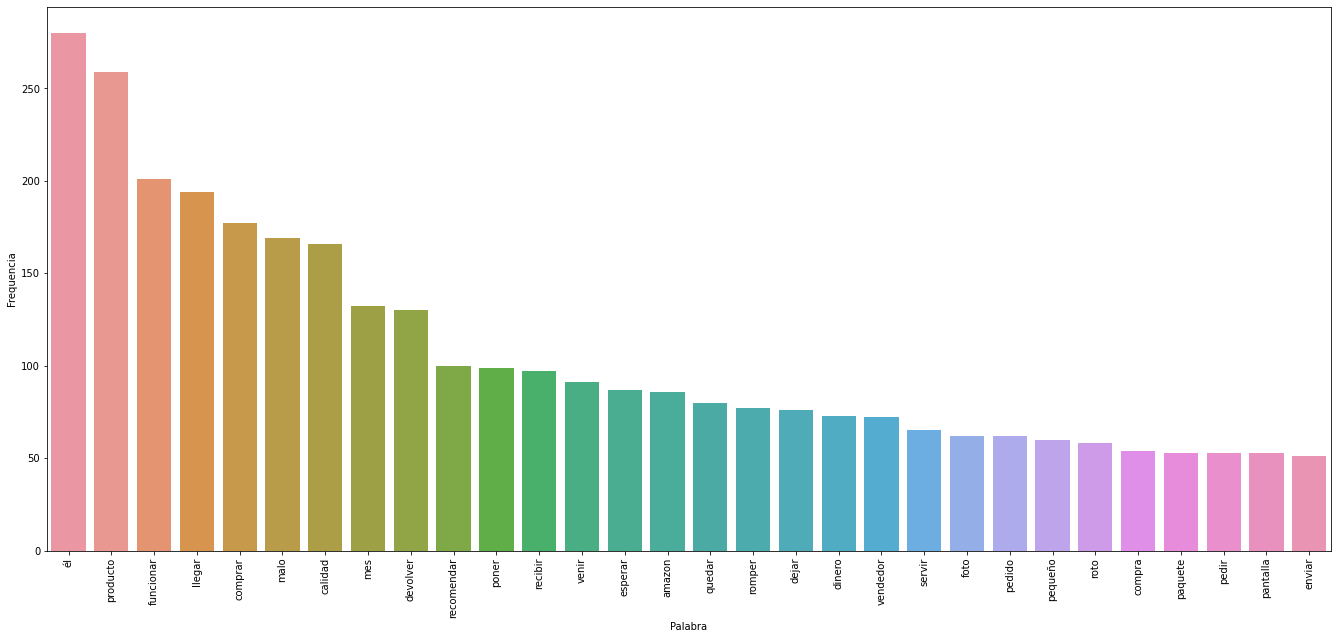

In [ ]:
palabras_mas_frecuentes_por_clase(df_test, "review_title_body_lemm", "stars", 1)

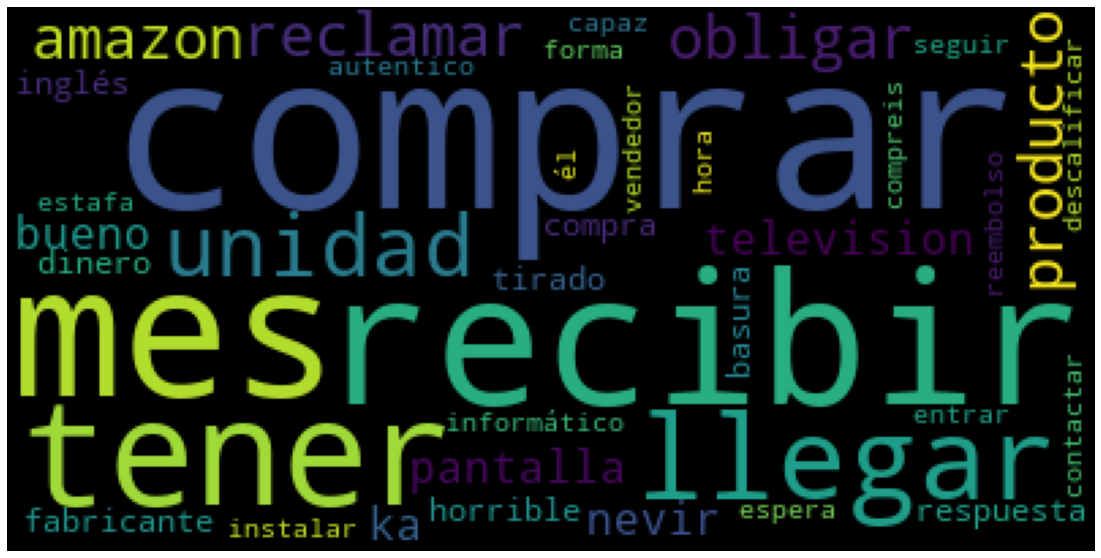

In [ ]:
nube_palabras_por_clase(df_train, "review_title_body_lemm", "stars", 1)

**Palabras mas frecuentes en la clase 2**

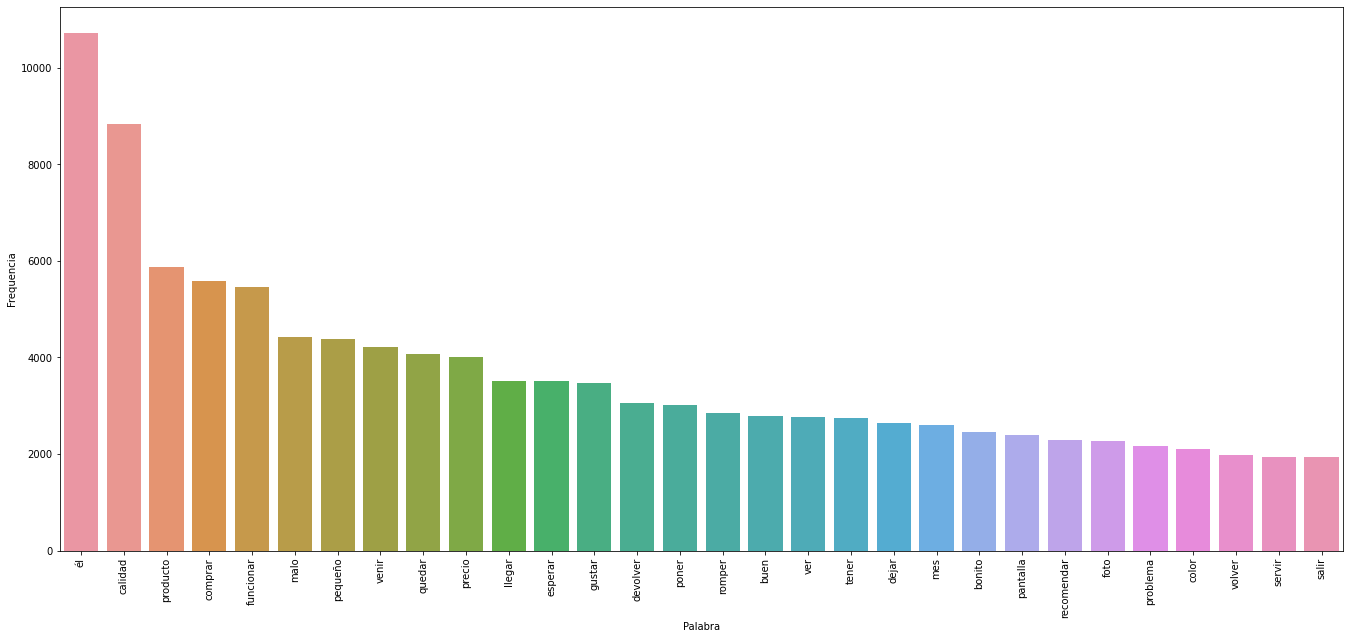

In [ ]:
palabras_mas_frecuentes_por_clase(df_train, "review_title_body_lemm", "stars", 2)

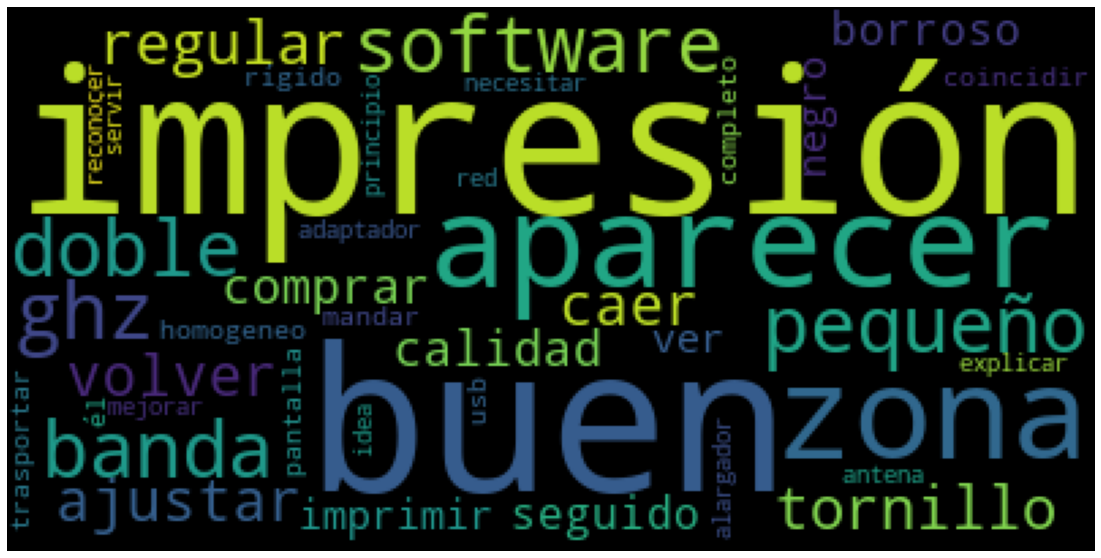

In [ ]:
nube_palabras_por_clase(df_train, "review_title_body_lemm", "stars", 2)

**Palabras mas frecuentes en la clase 3**

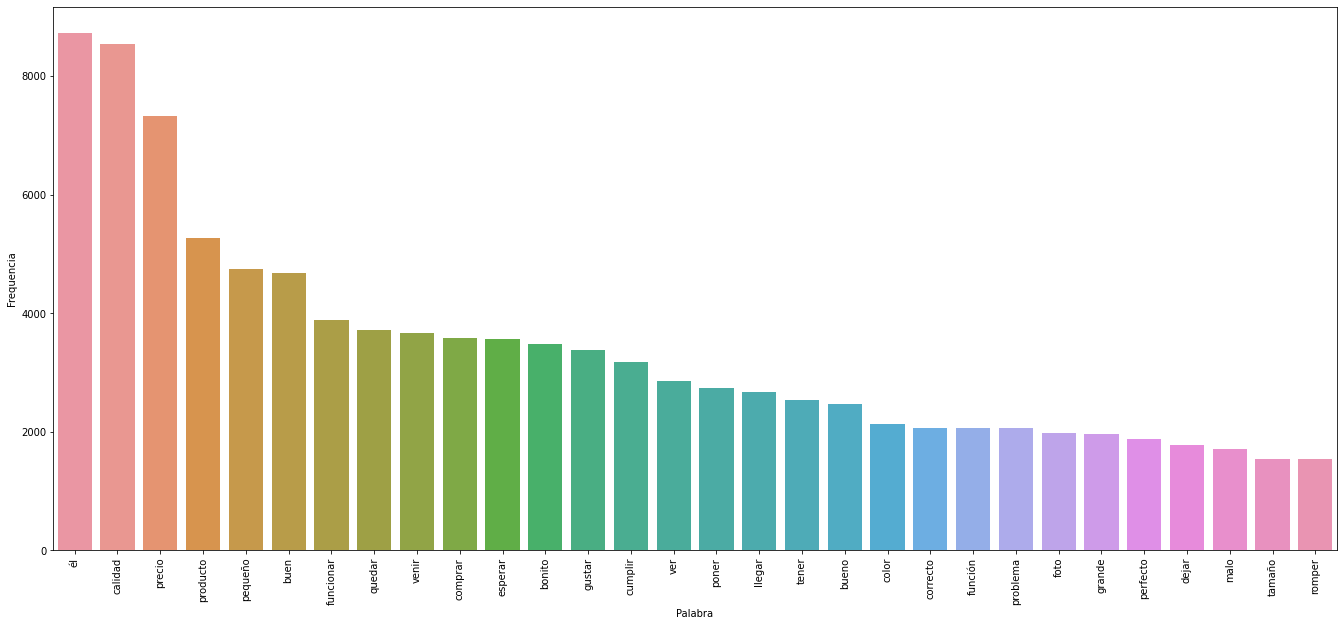

In [ ]:
palabras_mas_frecuentes_por_clase(df_train, "review_title_body_lemm", "stars", 3)

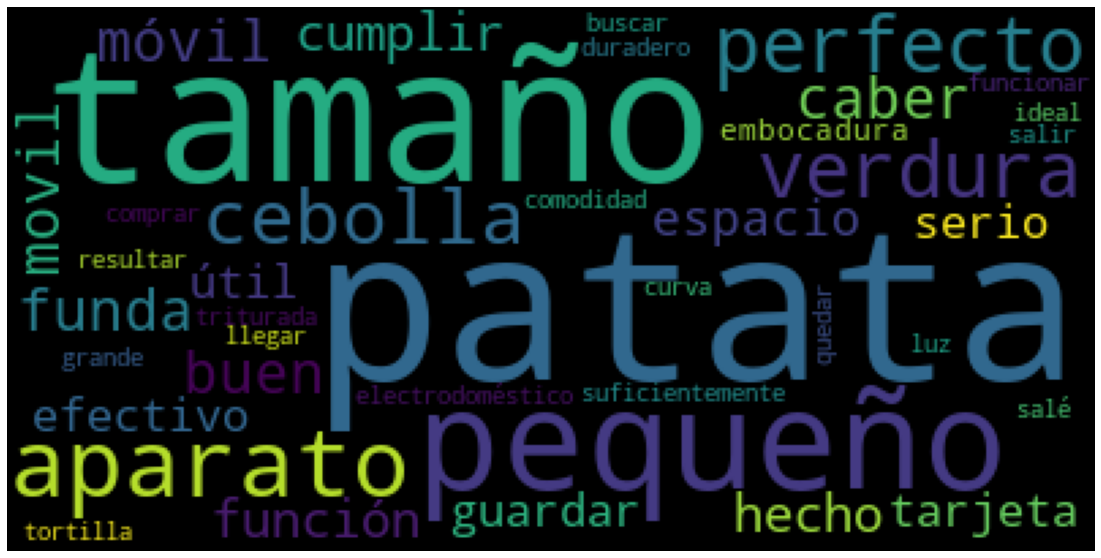

In [ ]:
nube_palabras_por_clase(df_train, "review_title_body_lemm", "stars", 3)

**Palabras mas frecuentes en la clase 4**

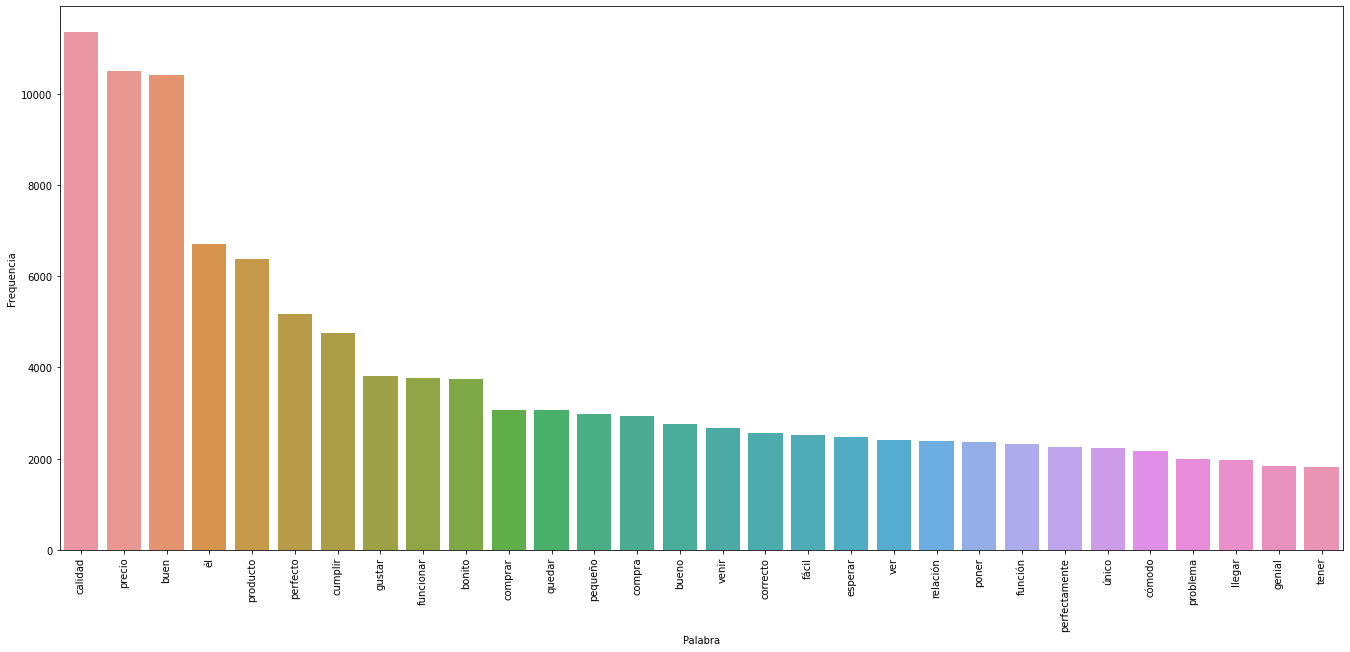

In [ ]:
palabras_mas_frecuentes_por_clase(df_train, "review_title_body_lemm", "stars", 4)

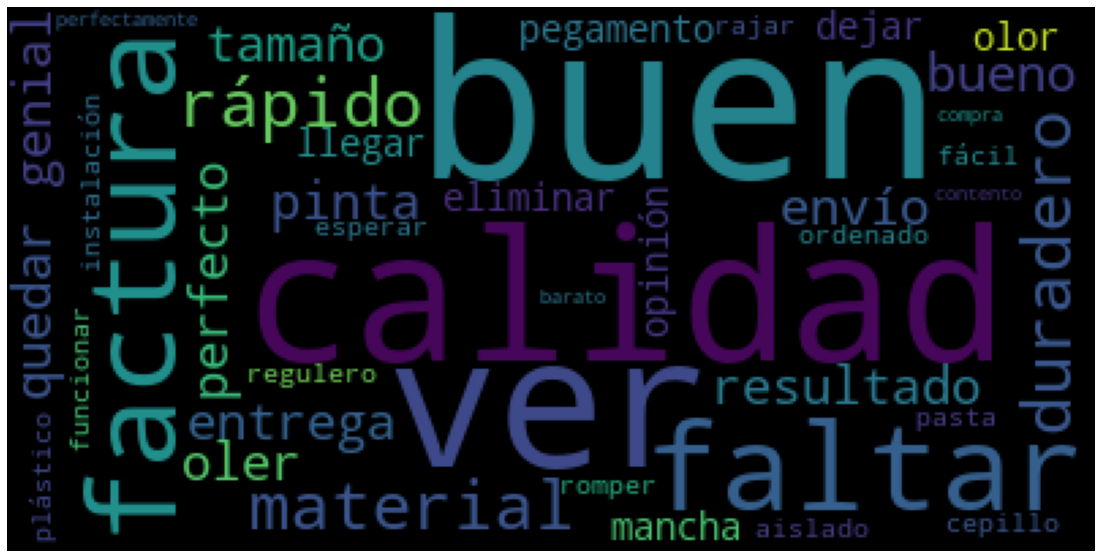

In [ ]:
nube_palabras_por_clase(df_train, "review_title_body_lemm", "stars", 4)

**Palabras mas frecuentes en la clase 5**

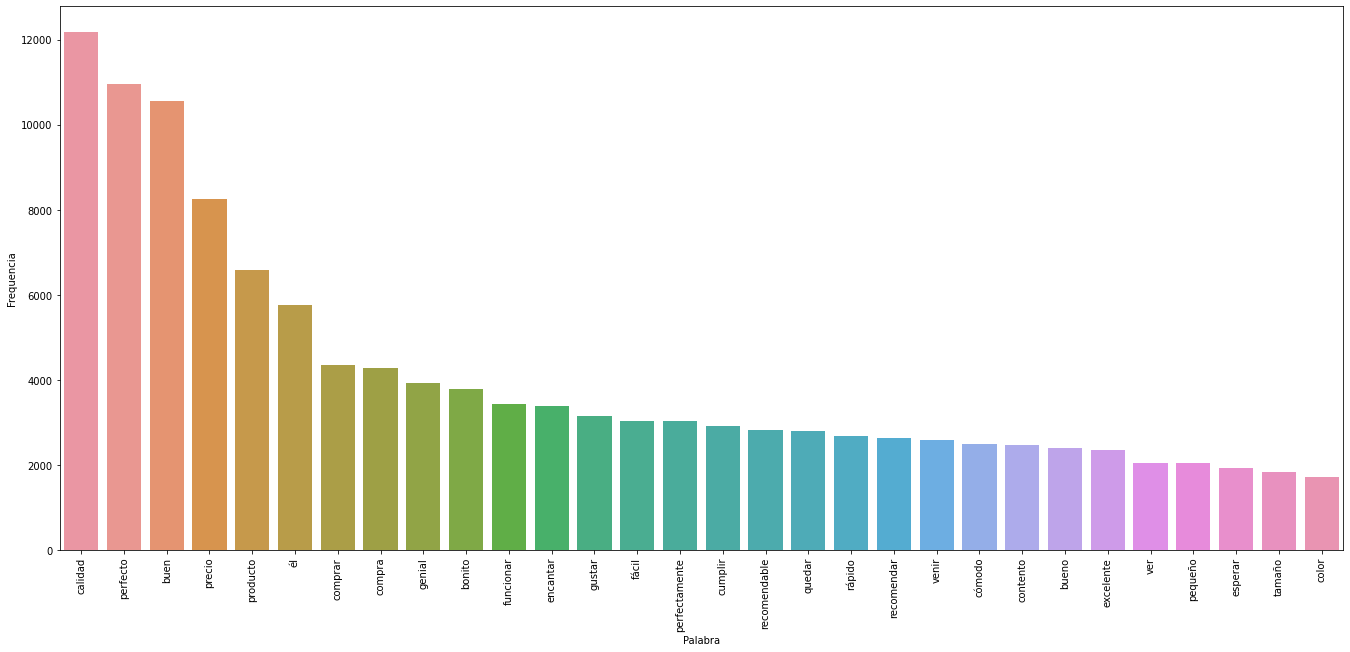

In [ ]:
palabras_mas_frecuentes_por_clase(df_train, "review_title_body_lemm", "stars", 5)

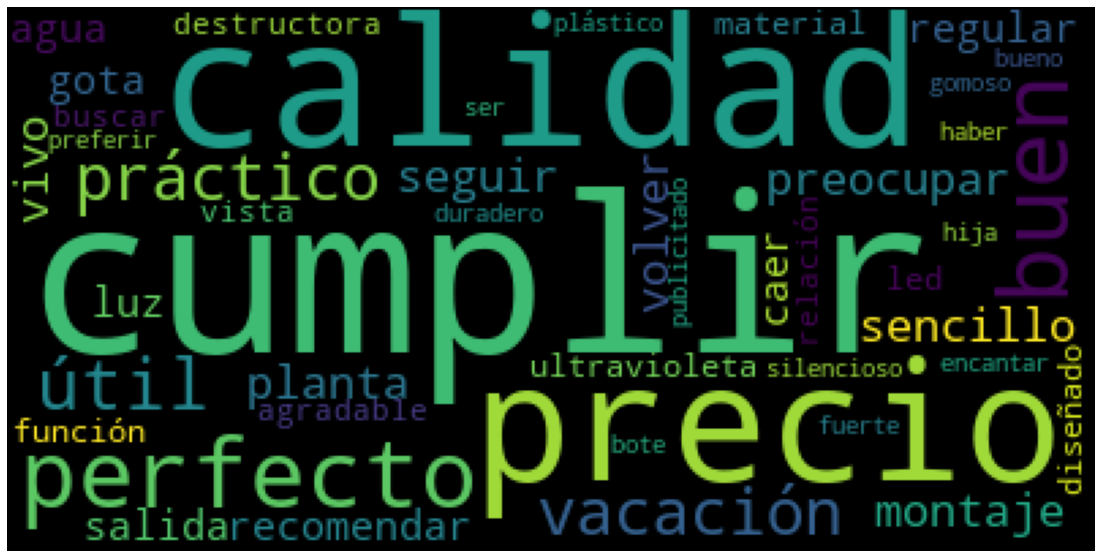

In [ ]:
nube_palabras_por_clase(df_train, "review_title_body_lemm", "stars", 5)

**Conclusion**:

Las clases 1 y 5 tienen palabras representativas como: 

basura, reclamar, horrible, obligar, descalificar, tirado, estafa, reembolso

practico, sencillo, agradable, calidad, recomendar, encantar, perfecto

**Problemas a futuro**:

La clase 2 contiene palabras de la clase 5

Las clases 2,3 y 4 tienen las mismas palabras frecuentes: Por ejemplo, buen y calidad

Todas las clases tienen las palabras: "él", "el" y "producto" entre las mas frecuentes

A continuacion se cargaran la libreria tensorflow y distintas clases de capas para redes neuronales

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from scipy.spatial.distance import cdist

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

El vocabulario extraido del corpus tendra a lo sumo 10000 palabras

In [ ]:
num_palabras = 10000

In [ ]:
print("Train:",df_train.shape)
print("Test:",df_test.shape)
print("Dev:",df_dev.shape)

Train: (200000, 6)
Test: (5000, 7)
Dev: (5000, 6)


Voy a instanciar la clase Tokenizer para extraer el vocabulario y despues reemplazar las palabras por tokens en todos los textos

In [ ]:
tokenizer = Tokenizer(num_words=num_palabras)

Considero extraer el vocabularia del conjunto de entrenamiento porque si lo hago con todo el corpus, el vocabulario podria incluir palabras que despues no aparezcan en el conjunto de entrenamiento, y algunas palabras serian ignoradas, siendo mas concreto, se perderia informacion para el entrenamiento. Ademas, el conjunto de entrenamiento es de 200000 textos (el 95%)

In [ ]:
%%time
tokenizer.fit_on_texts(df_train["review_title_body_lemm"]) #Graba un vocabulario de 10000 palabras donde cada palabra esta asociada a un token

CPU times: user 5.03 s, sys: 25.8 ms, total: 5.05 s
Wall time: 5.08 s


In [ ]:
tokenizer.word_index #Vocabulario

{'calidad': 1,
 'él': 2,
 'producto': 3,
 'precio': 4,
 'buen': 5,
 'funcionar': 6,
 'comprar': 7,
 'perfecto': 8,
 'llegar': 9,
 'venir': 10,
 'pequeño': 11,
 'quedar': 12,
 'gustar': 13,
 'esperar': 14,
 'bonito': 15,
 'malo': 16,
 'cumplir': 17,
 'poner': 18,
 'ver': 19,
 'compra': 20,
 'recomendar': 21,
 'tener': 22,
 'devolver': 23,
 'bueno': 24,
 'problema': 25,
 'mes': 26,
 'foto': 27,
 'dejar': 28,
 'color': 29,
 'romper': 30,
 'fácil': 31,
 'pantalla': 32,
 'correcto': 33,
 'función': 34,
 'pedir': 35,
 'genial': 36,
 'tamaño': 37,
 'rápido': 38,
 'perfectamente': 39,
 'poder': 40,
 'cómodo': 41,
 'grande': 42,
 'volver': 43,
 'servir': 44,
 'material': 45,
 'funda': 46,
 'durar': 47,
 'recibir': 48,
 'salir': 49,
 'caja': 50,
 'usar': 51,
 'recomendable': 52,
 'luz': 53,
 'amazon': 54,
 'año': 55,
 'querer': 56,
 'encantar': 57,
 'dar': 58,
 'plástico': 59,
 'original': 60,
 'llevar': 61,
 'relación': 62,
 'vendedor': 63,
 'valer': 64,
 'utilizar': 65,
 'contento': 66,
 'roto

Ahora voy a transformar los textos a tokens a partir del vocabulario

In [ ]:
x_train_tokens = tokenizer.texts_to_sequences(df_train["review_title_body_lemm"]) #Transforma los cada texto del corpus en base al vocabulario
x_test_tokens = tokenizer.texts_to_sequences(df_test["review_title_body_lemm"])
x_dev_tokens = tokenizer.texts_to_sequences(df_dev["review_title_body_lemm"])

Cantidad de tokens en cada secuencia

In [ ]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

Voy a definir un numero maximo de tokens para las secuencias

In [ ]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

30

**tf.keras.preprocessing.sequence.pad_sequences** se encarga de ajustar todas los arreglos de tokens en una dimension especifica.

Por ejemplo, si yo tengo este arreglo:

[[1], [2, 3], [4, 5, 6]]

y quiero que todas las filas tengan la misma dimension, tendria que ejecutar esto:

sequence = [[1], [2, 3], [4, 5, 6]];

tf.keras.preprocessing.sequence.pad_sequences(sequence)

Resultado:

[

  [0, 0, 1], 

  [0, 2, 3], 

  [4, 5, 6]

]

rellena los espacios vacios con ceros y trunca las filas cuya dimension es mayor a la maxima empezando por la derecha

In [ ]:
pad = 'pre'
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,padding=pad, truncating=pad)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,padding=pad, truncating=pad)
x_dev_pad = pad_sequences(x_dev_tokens, maxlen=max_tokens,padding=pad, truncating=pad)

# **Modelo**

El primer prototipo sera una red neuronal recurrente para clasificar textos de multiclases.

Las RNN estan capacitadas para reconocer patrones en datos secuenciales como por ejemplo: los textos.

El dataset de la problematica tiene una particularidad, las palabras positivas como "bueno" y "calidad" aparecen dentro de todas las clases (en la 1, 2, 3, 4 y 5), es decir, no podemos guiarnos por palabras claves para hacer la clasificacion, el modelo tiene que procesar secuencias de palabras y las RNN se enfocan precisamente en eso.

**Estrucutra del modelo**

La estructura es la siguiente:

In [ ]:
model = Sequential() #Modelo de capas secuenciales

In [ ]:
embedding_size = 8 #Tamaño de vectores de salida de la capa de incrustacion

**Capa de incrustacion (embedding)**

Los tokens estan en un rango de 1 - 10000, el RNN no puede trabajar con valores tan amplios.

Entones lo que se hace es transformar los tokens en vectores (en este caso de longitud 8), los numeros en los vectores varian entre -1 y 1

Como esta es la primera capa del RNN, su dimension sera igual al maximo numero de tokens

In [ ]:
model.add(Embedding(input_dim=num_palabras,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='Capa_incrustacion'))

**Unidad recurrente oculta (GRU)**

Estas unidades aseguran mantener en memoria la informacion importantes de las entradas y resuelven el problema de la desaparicion del gradiente que ocurre cuando se actualizan las unidades ocultas sin importar su relevancia, y por ende la function tanh reduce las actualizaciones hasta un punto cercano a cero

In [ ]:
model.add(GRU(units=16, return_sequences=True))

In [ ]:
model.add(GRU(units=8, return_sequences=True))

In [ ]:
model.add(GRU(units=4))

**Capa dense**

La capa Dense junto con la activacion "relu", permiten que la red neuronal pueda aumentar su performance, acelerar el aprendizaje y evitar la desaparicion del gradiente (porque la activacion relu reemplaza los pesos negativos por cero)

In [ ]:
model.add(Dense(16, activation='relu'))

**Capa de salida**

Devuelve un arreglo de 5 elementos, donde cada elemento se considera como la probabilidad de pertenecer a una clase en particular. Para concluir la prediccion voy a tomar la clase con mayor probabilidad de pertenencia

In [ ]:
model.add(Dense(5, activation='softmax'))

**Metrica de evaluacion**

Voy a usar el accuracy score porque la consigna es predecir las mismas clases que contiene la variable objetivo en los datasets.

Sin embargo, durante el desarrollo voy a usar matrices de confusion para ver como se comporta el modelo al predecir y tambien para encontrar errores de desarrollo

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

El modelo es de clasificacion multiclase, por lo tanto necesita que la variable objetivo este codificada en columnas binarias, en este caso 5 columnas porque son 5 clases

In [ ]:
df_train_cat = tf.keras.utils.to_categorical(df_train["stars"], num_classes=6)
df_test_cat = tf.keras.utils.to_categorical(df_test["stars"], num_classes=6)
df_dev_cat = tf.keras.utils.to_categorical(df_dev["stars"], num_classes=6)

In [ ]:
df_train_cat = np.delete(df_train_cat,0,axis=1)
df_test_cat = np.delete(df_test_cat,0,axis=1)
df_dev_cat = np.delete(df_dev_cat,0,axis=1)

In [ ]:
print("Train shape:",df_train_cat.shape)
print("Test shape:",df_test_cat.shape)
print("Dev shape:",df_dev_cat.shape)

Train shape: (200000, 5)
Test shape: (5000, 5)
Dev shape: (5000, 5)


In [ ]:
tf.random.set_seed(42)

modelo = Sequential(name="Modelo")

embedding_size = 8

modelo.add(Embedding(input_dim=num_palabras,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='Capa_incrustacion'))

modelo.add(GRU(units=16, return_sequences=True))

modelo.add(GRU(units=8, return_sequences=True))

modelo.add(GRU(units=4))

modelo.add(Dense(16, activation='relu'))

modelo.add(Dense(5, activation='softmax'))

modelo.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

modelo.summary()

Model: "Modelo"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_incrustacion (Embedding (None, 30, 8)             80000     
_________________________________________________________________
gru_3 (GRU)                  (None, 30, 16)            1248      
_________________________________________________________________
gru_4 (GRU)                  (None, 30, 8)             624       
_________________________________________________________________
gru_5 (GRU)                  (None, 4)                 168       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 85        
Total params: 82,205
Trainable params: 82,205
Non-trainable params: 0
________________________________________________________

In [ ]:
ruta = './mejor_modelo.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)
checkpoint    = ModelCheckpoint(ruta, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)
callback_list = [earlystopping, checkpoint]

In [ ]:
tf.random.set_seed(42)
historial_entrenamiento = modelo.fit(x_train_pad, df_train_cat, validation_data=(x_dev_pad, df_dev_cat), epochs=11, callbacks = callback_list, verbose=1)

Epoch 1/11
6250/6250 [==============================] - 151s 23ms/step - loss: 1.2643 - accuracy: 0.4273 - val_loss: 1.1431 - val_accuracy: 0.4910

Epoch 00001: val_accuracy improved from -inf to 0.49100, saving model to ./mejor_modelo.hdf5
Epoch 2/11
6250/6250 [==============================] - 145s 23ms/step - loss: 1.1047 - accuracy: 0.5127 - val_loss: 1.1314 - val_accuracy: 0.4982

Epoch 00002: val_accuracy improved from 0.49100 to 0.49820, saving model to ./mejor_modelo.hdf5
Epoch 3/11
6250/6250 [==============================] - 141s 22ms/step - loss: 1.0767 - accuracy: 0.5276 - val_loss: 1.1359 - val_accuracy: 0.4948

Epoch 00003: val_accuracy did not improve from 0.49820
Epoch 4/11
6250/6250 [==============================] - 140s 22ms/step - loss: 1.0589 - accuracy: 0.5393 - val_loss: 1.1296 - val_accuracy: 0.5062

Epoch 00004: val_accuracy improved from 0.49820 to 0.50620, saving model to ./mejor_modelo.hdf5
Epoch 5/11
6250/6250 [==============================] - 139s 22ms/st

El modelo ya esta entrenado, ahora voy a evaluarlo con matrices de confusion pero la metrica definitiva es el accuracy score

In [ ]:
def matriz_confusion_predicciones(model,x,y):
  predicciones = model.predict(x)
  predicciones = np.argmax(predicciones, axis=1) + 1
  cm = confusion_matrix(y,predicciones, normalize='true')
  x_axis_labels = [1,2,3,4,5]
  y_axis_labels = [1,2,3,4,5]
  plt.figure(figsize=(23,10))
  sns.heatmap(cm, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
  plt.show()

**Matriz de confusion en train**

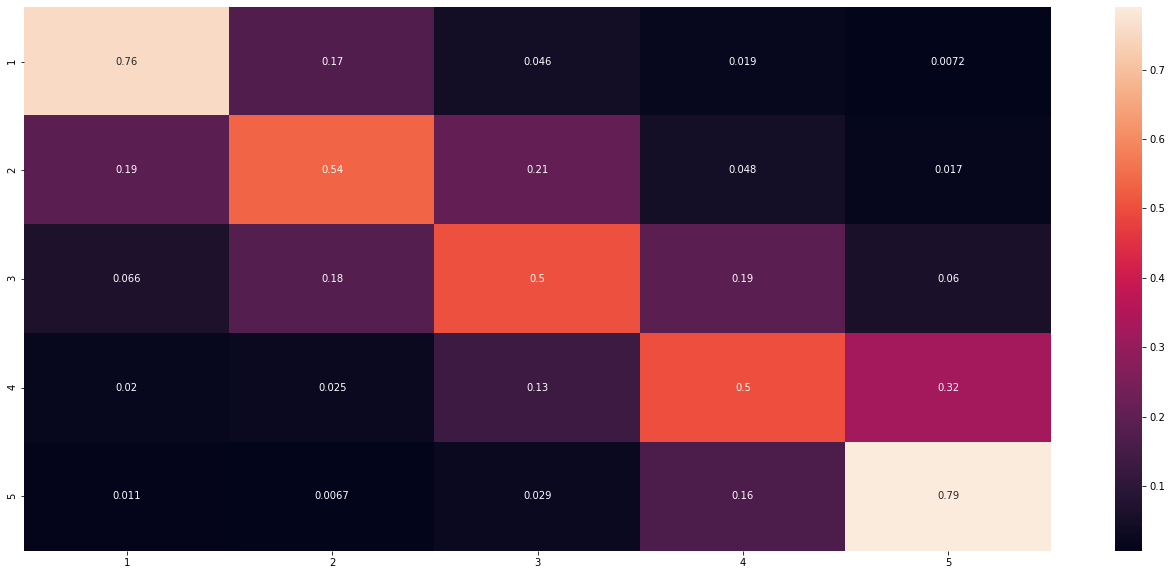

In [ ]:
matriz_confusion_predicciones(modelo,x_train_pad,df_train["stars"])

**Matriz de confusion en test**

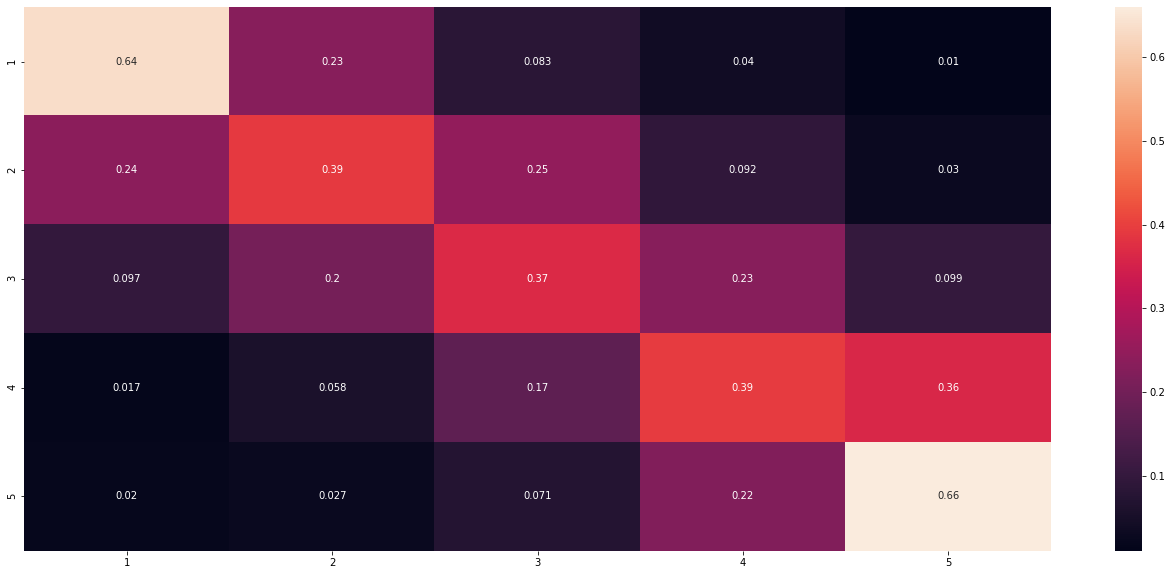

In [ ]:
matriz_confusion_predicciones(modelo,x_test_pad,df_test["stars"])

**Matriz de confusion en dev**

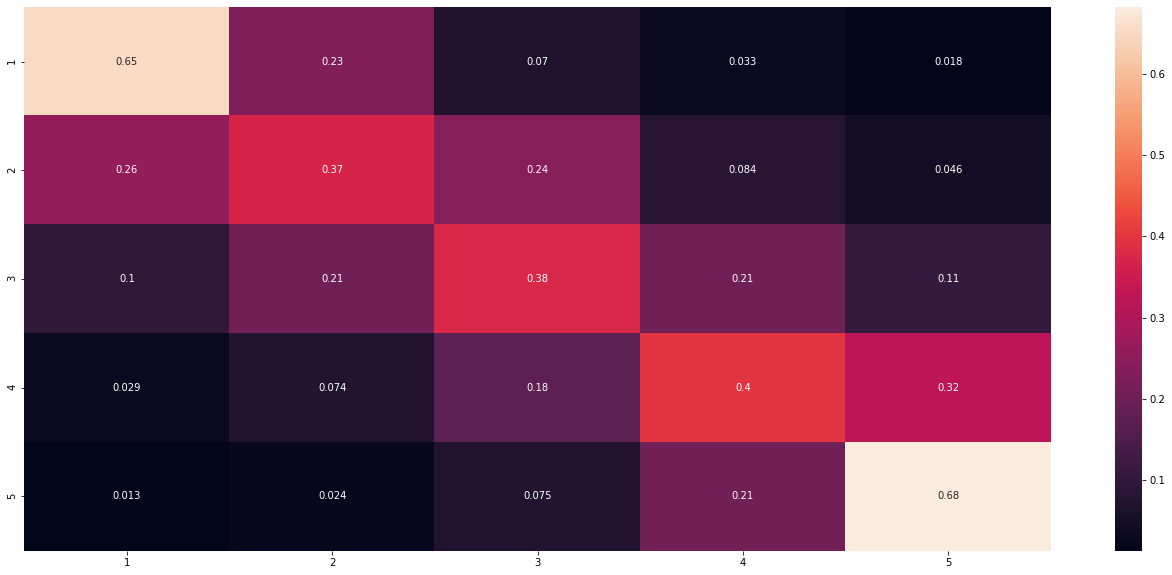

In [ ]:
matriz_confusion_predicciones(modelo,x_dev_pad,df_dev["stars"])

Como dije antes en el EDA, las clases 2,3 y 4 tienen rasgos muy similares y a continuacion voy a retirar las palabras que causan la confusion 

In [ ]:
bolsa_1 = ["él", "el", "producto"] #para 1,2,3,4,5
bolsa_2 = ["buen","calidad","bueno","buena","comprar", "funcionar", "pequeño", "precio","esperar","llegar","gustar","ver","poner","tener"] #para 2,3
bolsa_3 = ["bonito"] #para 3
bolsa_4 = ["quedar","venir"] #para 3,4
bolsa_5 = ["perfecto","precio"] #para 4


filtro_train = (df_train["stars"] == 2) | (df_train["stars"] == 3)
filtro_test = (df_test["stars"] == 2) | (df_test["stars"] == 3)
filtro_dev = (df_dev["stars"] == 2) | (df_dev["stars"] == 3)

filtro_train2 = (df_train["stars"] == 3)
filtro_test2 = (df_test["stars"] == 3)
filtro_dev2 = (df_dev["stars"] == 3)

filtro_train3 = (df_train["stars"] == 3) | (df_train["stars"] == 4)
filtro_test3 = (df_test["stars"] == 3) | (df_test["stars"] == 4)
filtro_dev3 = (df_dev["stars"] == 3) | (df_dev["stars"] == 4)

filtro_train4 = (df_train["stars"] == 4)
filtro_test4 = (df_test["stars"] == 4)
filtro_dev4 = (df_dev["stars"] == 4)

In [ ]:
for palabra in bolsa_1:
  df_train["review_title_body_lemm"] = df_train["review_title_body_lemm"].str.replace(palabra,'')
  df_test["review_title_body_lemm"] = df_test["review_title_body_lemm"].str.replace(palabra,'')
  df_dev["review_title_body_lemm"] = df_dev["review_title_body_lemm"].str.replace(palabra,'')

In [ ]:
for palabra in bolsa_2:
  df_train.loc[filtro_train,"review_title_body_lemm"] = df_train.loc[filtro_train,"review_title_body_lemm"].str.replace(palabra,'')
  df_test.loc[filtro_test,"review_title_body_lemm"] = df_test.loc[filtro_test,"review_title_body_lemm"].str.replace(palabra,'')
  df_dev.loc[filtro_dev,"review_title_body_lemm"] = df_dev.loc[filtro_dev,"review_title_body_lemm"].str.replace(palabra,'')

In [ ]:
for palabra in bolsa_3:
  df_train.loc[filtro_train2,"review_title_body_lemm"] = df_train.loc[filtro_train2,"review_title_body_lemm"].str.replace(palabra,'')
  df_test.loc[filtro_test2,"review_title_body_lemm"] = df_test.loc[filtro_test2,"review_title_body_lemm"].str.replace(palabra,'')
  df_dev.loc[filtro_dev2,"review_title_body_lemm"] = df_dev.loc[filtro_dev2,"review_title_body_lemm"].str.replace(palabra,'')

In [ ]:
for palabra in bolsa_4:
  df_train.loc[filtro_train3,"review_title_body_lemm"] = df_train.loc[filtro_train3,"review_title_body_lemm"].str.replace(palabra,'')
  df_test.loc[filtro_test3,"review_title_body_lemm"] = df_test.loc[filtro_test3,"review_title_body_lemm"].str.replace(palabra,'')
  df_dev.loc[filtro_dev3,"review_title_body_lemm"] = df_dev.loc[filtro_dev3,"review_title_body_lemm"].str.replace(palabra,'')

In [ ]:
for palabra in bolsa_5:
  df_train.loc[filtro_train4,"review_title_body_lemm"] = df_train.loc[filtro_train4,"review_title_body_lemm"].str.replace(palabra,'')
  df_test.loc[filtro_test4,"review_title_body_lemm"] = df_test.loc[filtro_test4,"review_title_body_lemm"].str.replace(palabra,'')
  df_dev.loc[filtro_dev4,"review_title_body_lemm"] = df_dev.loc[filtro_dev4,"review_title_body_lemm"].str.replace(palabra,'')

In [ ]:
tokenizer = Tokenizer(num_words=num_palabras)

In [ ]:
%%time
tokenizer.fit_on_texts(df_train["review_title_body_lemm"])

CPU times: user 4.82 s, sys: 16.6 ms, total: 4.83 s
Wall time: 4.87 s


In [ ]:
x_train_tokens = tokenizer.texts_to_sequences(df_train["review_title_body_lemm"]) #Transforma los cada texto del corpus en base al vocabulario
x_test_tokens = tokenizer.texts_to_sequences(df_test["review_title_body_lemm"])
x_dev_tokens = tokenizer.texts_to_sequences(df_dev["review_title_body_lemm"])

In [ ]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)

In [ ]:
max_tokens

28

In [ ]:
pad = 'pre'
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,padding=pad, truncating=pad)
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,padding=pad, truncating=pad)
x_dev_pad = pad_sequences(x_dev_tokens, maxlen=max_tokens,padding=pad, truncating=pad)

In [ ]:
tf.random.set_seed(42)

modelo = Sequential(name="Modelo")

embedding_size = 8

modelo.add(Embedding(input_dim=num_palabras,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='Capa_incrustacion'))

modelo.add(GRU(units=16, return_sequences=True))

modelo.add(GRU(units=8, return_sequences=True))

modelo.add(GRU(units=4))

modelo.add(Dense(16, activation='relu'))

modelo.add(Dense(5, activation='softmax'))

modelo.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

modelo.summary()

Model: "Modelo"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_incrustacion (Embedding (None, 28, 8)             80000     
_________________________________________________________________
gru_6 (GRU)                  (None, 28, 16)            1248      
_________________________________________________________________
gru_7 (GRU)                  (None, 28, 8)             624       
_________________________________________________________________
gru_8 (GRU)                  (None, 4)                 168       
_________________________________________________________________
dense_4 (Dense)              (None, 16)                80        
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 85        
Total params: 82,205
Trainable params: 82,205
Non-trainable params: 0
________________________________________________________

In [ ]:
ruta = './mejor_modelo.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)
checkpoint    = ModelCheckpoint(ruta, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)
callback_list = [earlystopping, checkpoint]

In [ ]:
tf.random.set_seed(42)
historial_entrenamiento = modelo.fit(x_train_pad, df_train_cat, validation_data=(x_dev_pad, df_dev_cat), epochs=12, callbacks=callback_list, verbose=1)

Epoch 1/12
6250/6250 [==============================] - 138s 21ms/step - loss: 1.0643 - accuracy: 0.5178 - val_loss: 0.8785 - val_accuracy: 0.6092

Epoch 00001: val_accuracy improved from -inf to 0.60920, saving model to ./mejor_modelo.hdf5
Epoch 2/12
6250/6250 [==============================] - 134s 21ms/step - loss: 0.8229 - accuracy: 0.6360 - val_loss: 0.8139 - val_accuracy: 0.6352

Epoch 00002: val_accuracy improved from 0.60920 to 0.63520, saving model to ./mejor_modelo.hdf5
Epoch 3/12
6250/6250 [==============================] - 135s 22ms/step - loss: 0.7532 - accuracy: 0.6699 - val_loss: 0.8135 - val_accuracy: 0.6370

Epoch 00003: val_accuracy improved from 0.63520 to 0.63700, saving model to ./mejor_modelo.hdf5
Epoch 4/12
6250/6250 [==============================] - 135s 22ms/step - loss: 0.7254 - accuracy: 0.6817 - val_loss: 0.8095 - val_accuracy: 0.6492

Epoch 00004: val_accuracy improved from 0.63700 to 0.64920, saving model to ./mejor_modelo.hdf5
Epoch 5/12
6250/6250 [=====

**Matriz de confusion en train**

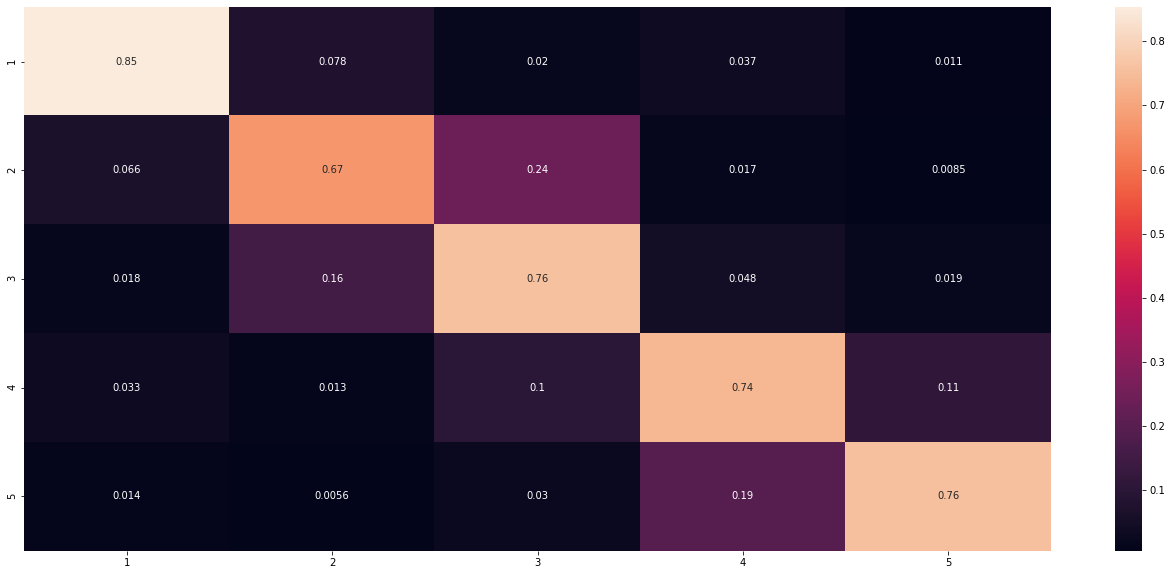

In [ ]:
matriz_confusion_predicciones(modelo,x_train_pad,df_train["stars"])

In [ ]:
preds_train = np.argmax(modelo.predict(x_train_pad),axis=1)+1
print("Accuracy score train:",accuracy_score(df_train["stars"],preds_train))

Accuracy score train: 0.755785


**Matriz de confusion en test**

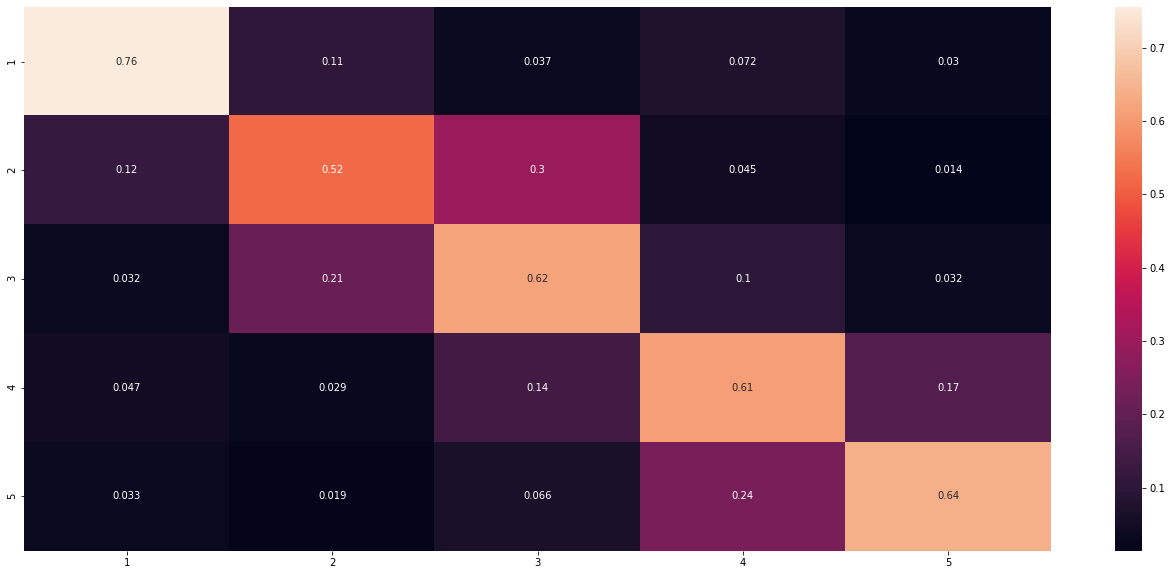

In [ ]:
matriz_confusion_predicciones(modelo,x_test_pad,df_test["stars"])

In [ ]:
preds_test = np.argmax(modelo.predict(x_test_pad),axis=1)+1
print("Accuracy score test:",accuracy_score(df_test["stars"],preds_test))

Accuracy score test: 0.629


**Matriz de confusion en dev**

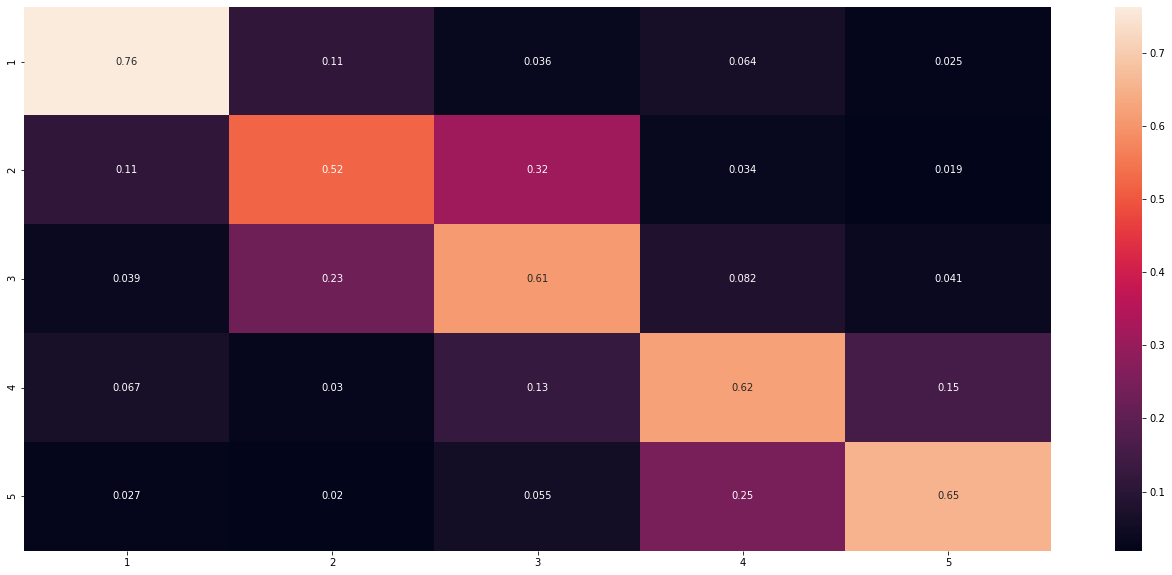

In [ ]:
matriz_confusion_predicciones(modelo,x_dev_pad,df_dev["stars"])

In [ ]:
preds_dev = np.argmax(modelo.predict(x_dev_pad),axis=1)+1
print("Accuracy score dev:",accuracy_score(df_dev["stars"],preds_dev))

Accuracy score dev: 0.6332


# **RNN Regresiva**

Voy a experimentar el mismo modelo pero con otro tipo de salida, la ultima capa tendra una activacion lineal para estimar el rating de la review en forma numerica, y no como una clase.
Hay un problema con esto y es que la consigna pide predecir valores en el conjunto {1,2,3,4,5}, por lo tanto, voy a aplicar un redondeo en las predicciones para evaluar con accuracy

In [ ]:
tf.random.set_seed(42)

modelo = Sequential(name="Modelo_regresivo")

embedding_size = 12

modelo.add(Embedding(input_dim=num_palabras,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='Capa_incrustacion'))

modelo.add(GRU(units=16, return_sequences=True))

modelo.add(GRU(units=8, return_sequences=True))

modelo.add(GRU(units=4))

modelo.add(Dense(8, activation='relu'))

modelo.add(Dense(1, activation='linear'))

modelo.compile(loss=tf.keras.losses.MAE,
              optimizer='adam',
              metrics=[tf.keras.losses.MAE])

modelo.summary()

Model: "Modelo_regresivo"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Capa_incrustacion (Embedding (None, 28, 12)            120000    
_________________________________________________________________
gru_9 (GRU)                  (None, 28, 16)            1440      
_________________________________________________________________
gru_10 (GRU)                 (None, 28, 8)             624       
_________________________________________________________________
gru_11 (GRU)                 (None, 4)                 168       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 122,281
Trainable params: 122,281
Non-trainable params: 0
____________________________________________

In [ ]:
ruta = './mejor_modelo_regresivo.hdf5'

earlystopping = EarlyStopping(monitor = 'val_mean_absolute_error', 
                              mode = 'min' , 
                              patience = 15,
                              verbose = 1)
checkpoint    = ModelCheckpoint(ruta, 
                                monitor = 'val_mean_absolute_error', 
                                mode='min', 
                                save_best_only=True, 
                                verbose = 1)
callback_list = [earlystopping, checkpoint]

In [ ]:
tf.random.set_seed(42)
historial_entrenamiento = modelo.fit(x_train_pad, df_train["stars"], validation_data=(x_test_pad, df_test["stars"]), epochs=7, verbose=1, callbacks=callback_list)

Epoch 1/7
6250/6250 [==============================] - 145s 22ms/step - loss: 0.8905 - mean_absolute_error: 0.8905 - val_loss: 0.5772 - val_mean_absolute_error: 0.5772

Epoch 00001: val_mean_absolute_error improved from inf to 0.57723, saving model to ./mejor_modelo_regresivo.hdf5
Epoch 2/7
6250/6250 [==============================] - 141s 22ms/step - loss: 0.5358 - mean_absolute_error: 0.5358 - val_loss: 0.5317 - val_mean_absolute_error: 0.5317

Epoch 00002: val_mean_absolute_error improved from 0.57723 to 0.53166, saving model to ./mejor_modelo_regresivo.hdf5
Epoch 3/7
6250/6250 [==============================] - 143s 23ms/step - loss: 0.4791 - mean_absolute_error: 0.4791 - val_loss: 0.5076 - val_mean_absolute_error: 0.5076

Epoch 00003: val_mean_absolute_error improved from 0.53166 to 0.50759, saving model to ./mejor_modelo_regresivo.hdf5
Epoch 4/7
6250/6250 [==============================] - 142s 23ms/step - loss: 0.4467 - mean_absolute_error: 0.4467 - val_loss: 0.5046 - val_mean_a

In [ ]:
from sklearn.metrics import r2_score

**Matriz de confusion en train**

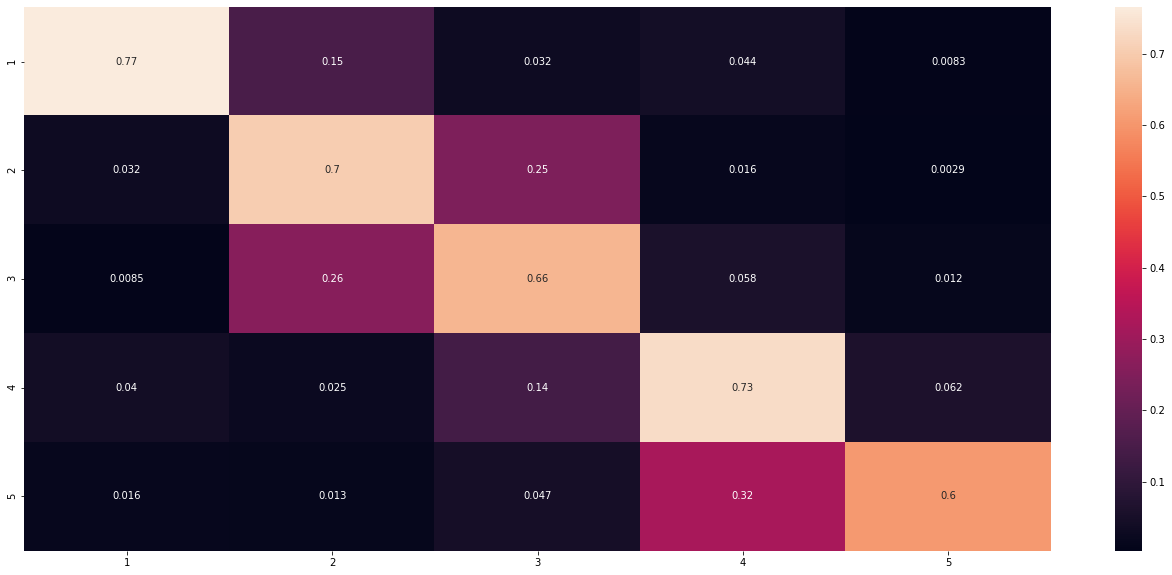

Accuracy Score train: 0.693565
R2 Score train: 0.6389120856187469


In [ ]:
pred = modelo.predict(x_train_pad)
preds_final = []
for x in pred:
  a = np.floor(x+0.5).astype(int)[0]
  preds_final.append(a)

cm = confusion_matrix(df_train["stars"],preds_final, normalize='true')
x_axis_labels = [1,2,3,4,5]
y_axis_labels = [1,2,3,4,5]
plt.figure(figsize=(23,10))
sns.heatmap(cm, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.show()

print("Accuracy Score train: "+str(accuracy_score(preds_final,df_train["stars"])))
print("R2 Score train: "+str(r2_score(pred,df_train["stars"])))

**Matriz de confusion en test**

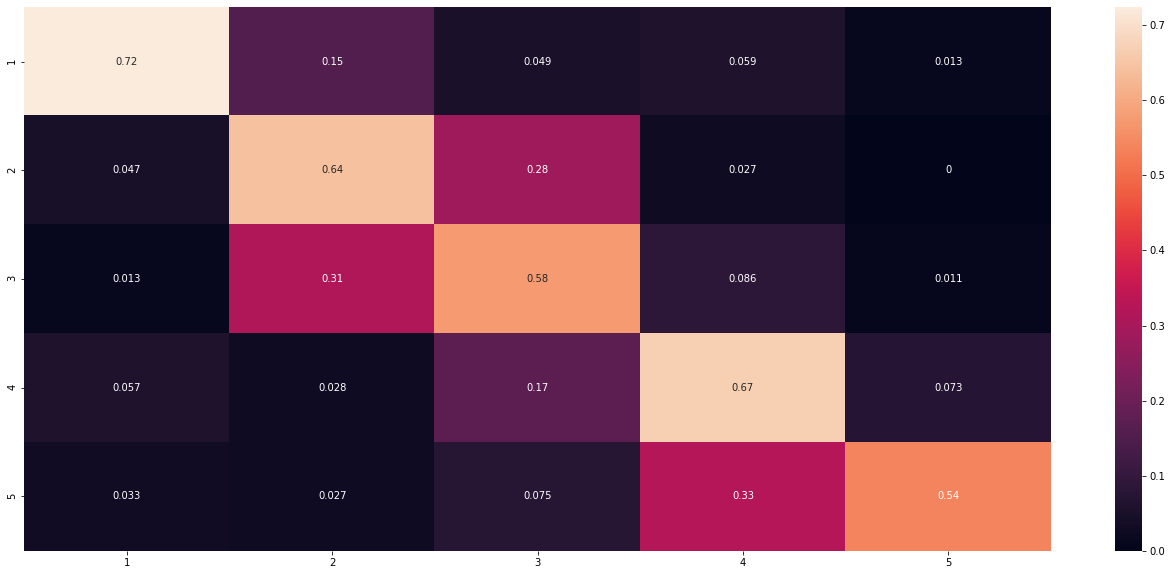

Accuracy Score test: 0.6302
R2 Score test: 0.49350348309616254


In [ ]:
pred = modelo.predict(x_test_pad)
preds_final = []
for x in pred:
  a = np.floor(x+0.5).astype(int)[0]
  preds_final.append(a)

cm = confusion_matrix(df_test["stars"],preds_final, normalize='true')
x_axis_labels = [1,2,3,4,5]
y_axis_labels = [1,2,3,4,5]
plt.figure(figsize=(23,10))
sns.heatmap(cm, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.show()

print("Accuracy Score test: "+str(accuracy_score(preds_final,df_test["stars"])))
print("R2 Score test: "+str(r2_score(pred,df_test["stars"])))

**Matriz de confusion en dev**

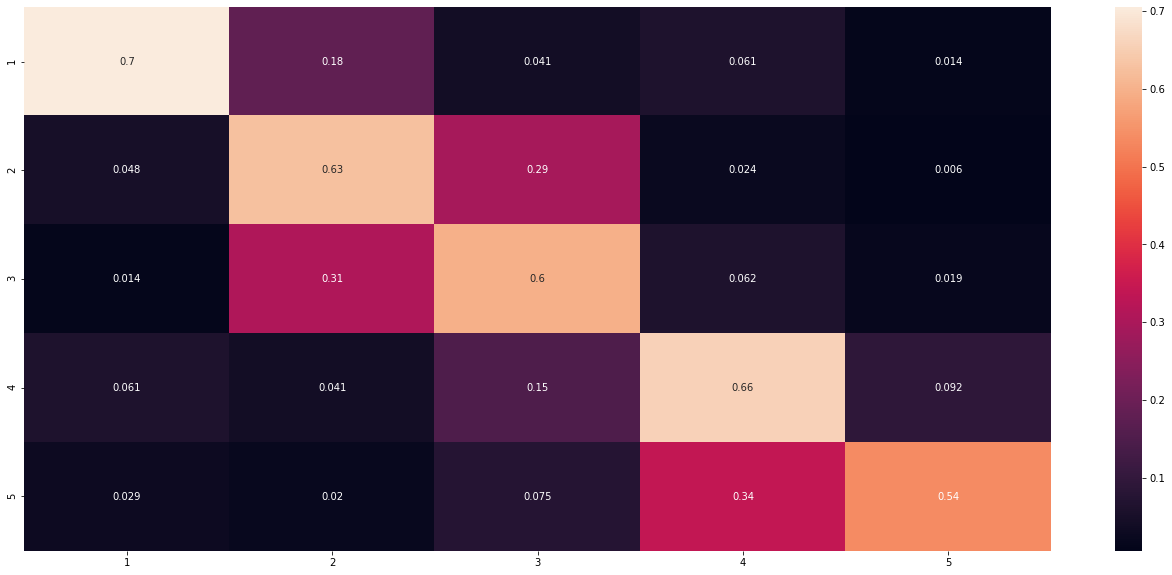

Accuracy Score dev: 0.6246
R2 Score dev: 0.4853295987072288


In [ ]:
pred = modelo.predict(x_dev_pad)
preds_final = []
for x in pred:
  a = np.floor(x+0.5).astype(int)[0]
  preds_final.append(a)

cm = confusion_matrix(df_dev["stars"],preds_final, normalize='true')
x_axis_labels = [1,2,3,4,5]
y_axis_labels = [1,2,3,4,5]
plt.figure(figsize=(23,10))
sns.heatmap(cm, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.show()

print("Accuracy Score dev: "+str(accuracy_score(preds_final,df_dev["stars"])))
print("R2 Score dev: "+str(r2_score(pred,df_dev["stars"])))

La RNN regresiva tuvo un comportamiento similar a la RNN de clasificacion, pero el accuracy es mas equitativo para todas las clases, en cambio, la RNN de clasificacion tiene mayor acuracy para las clasess 1 y 5.



**Modelos benchmark**

A continuacion voy a comparar el primer prototipo con otros modelos para seleccionar un modelo definitivo

In [ ]:
list_train = list(df_train["review_title_body_lemm"])

list_test = list(df_test["review_title_body_lemm"])

list_dev = list(df_dev["review_title_body_lemm"])

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000

# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features)

In [ ]:
matriz_train = cou_vec.fit_transform(list_train)
matriz_train = matriz_train.toarray()
print("Shape train:",matriz_train.shape)

matriz_test = cou_vec.transform(list_test)
matriz_test = matriz_test.toarray()
print("Shape test:",matriz_test.shape)

matriz_dev = cou_vec.transform(list_dev)
matriz_dev = matriz_dev.toarray()
print("Shape dev:",matriz_dev.shape)

Shape train: (200000, 1000)
Shape test: (5000, 1000)
Shape dev: (5000, 1000)


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
def confusion(ytest,y_pred):
    names=[1,2,3,4,5]
    plt.figure(figsize=(23,10))
    cm=confusion_matrix(ytest,y_pred,normalize='true')
    f,ax=plt.subplots(figsize=(23,10))
    sns.heatmap(cm,annot=True,ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return

In [ ]:
nb = GaussianNB(var_smoothing=(1/10**9))
params_NB = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
gs_NB = GridSearchCV(estimator=nb, 
                 param_grid=params_NB, 
                 cv=5,   # use any cross validation technique 
                 verbose=1,
                 scoring='accuracy')
#gs_NB.fit(matriz_train,df_train["stars"])

best_params_nb = {'var_smoothing': 1e-09}
nb.fit(matriz_train,df_train["stars"])
print("Naive bayes")
print("="*32)
print("Best parans")
print(best_params_nb)
print("="*32)
print("Train accuracy:", accuracy_score(df_train["stars"],nb.predict(matriz_train)))
print("="*32)
print("Test accuracy:", accuracy_score(df_test["stars"],nb.predict(matriz_test)))
print("="*32)
print("Dev accuracy:", accuracy_score(df_dev["stars"],nb.predict(matriz_dev)))

Naive bayes
Best parans
{'var_smoothing': 1e-09}
Train accuracy: 0.548555
Test accuracy: 0.5418
Dev accuracy: 0.5478


In [ ]:
rf = RandomForestClassifier(bootstrap=False,max_depth=None,max_features='sqrt',min_samples_leaf=4,min_samples_split=5,n_estimators=5)

random_forest_grid = {'bootstrap': [True, False],
               'max_depth': [1,5,None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [1,5]}

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_forest_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = 1)

#rf_random.fit(matriz_train,df_train["stars"])

best_params_random_forest = {'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 5}

rf.fit(matriz_train,df_train["stars"])

print("Random Forest Classsifier")
print("="*32)
print("Best parans")
print(best_params_random_forest)
print("="*32)
print("Train accuracy:", accuracy_score(df_train["stars"],rf.predict(matriz_train)))
print("="*32)
print("Test accuracy:", accuracy_score(df_test["stars"],rf.predict(matriz_test)))
print("="*32)
print("Dev accuracy:", accuracy_score(df_dev["stars"],rf.predict(matriz_dev)))

Random Forest Classsifier
Best parans
{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 5}
Train accuracy: 0.706625
Test accuracy: 0.5926
Dev accuracy: 0.5914


Aprovechando el random forest, voy a investigar cuales son las palabras mas importantes segun el modelo

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


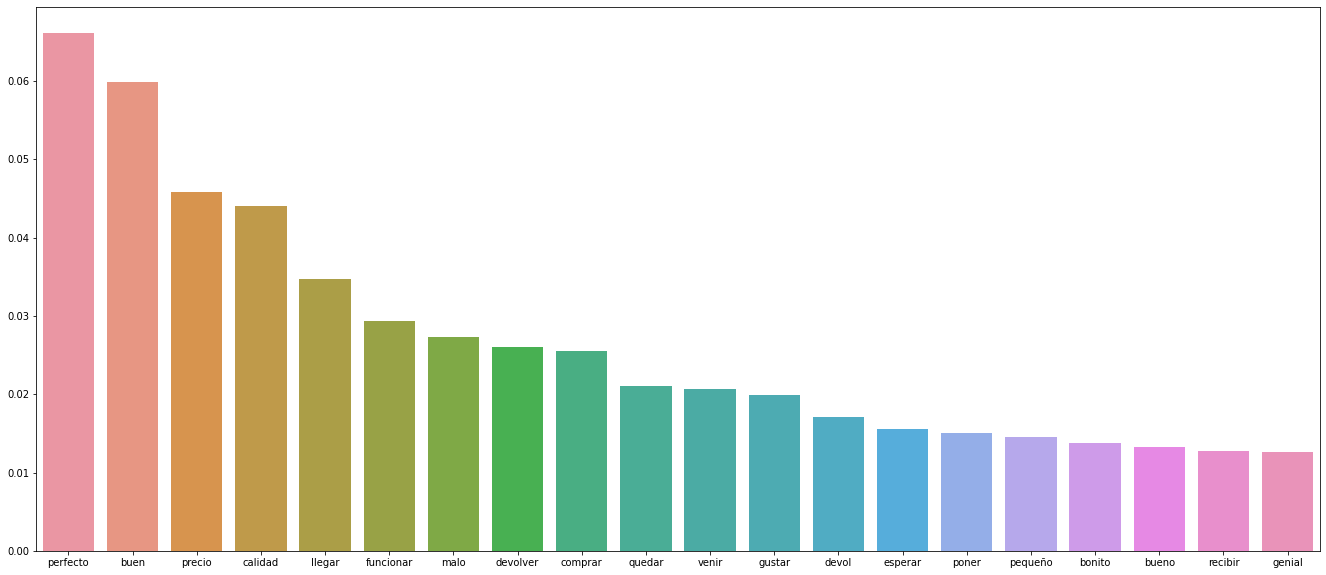

In [ ]:
# Le preguntamos la importancia de cada feature (cada palabra)
importances = rf.feature_importances_
# Tomamos la lista de palabras
all_words = cou_vec.get_feature_names()
columns = all_words

# Ordenamos por importnacia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
indices = indices[:20]
selected_columns = [columns[i] for i in indices]
selected_importances = importances[indices]

# Por ultimo graficamos
plt.figure(figsize = (23,10))
sns.barplot(selected_columns, selected_importances)
plt.show()

El grafico coincide con el EDA realizado porque es una union de las palabras mas frecuentes entre todas las clases

**Seleccion del modelo**:

Todos los modelos desarrollados hasta ahora tienen rendimiento similar, pero, los modelos benchmark tienen una desventaja, y es que a pesar de funcionar casi igual que las RNN's, necesitan una entrada de 1000 numeros, en cambio, la RNN necesita solo 28 numeros como entrada.

Si el dataset aumenta, los benchmarks necesitaran agrandar sus entradas y se volveria insostenible, ademas que el costo computacional aumentaria exponencialmente.

Por lo tanto, las RNN's son mas escalables y entre los 2 tipos de RNN (clasificacion y regresion) yo elijo el de regresion porque hubo menor confusion entre las clases 1 y 5 y ademas el error absoluto es en promedio menor a 0.5, por ejemplo:
Una review de clase 3 puede ser predicha como 2.6, pero al aplicar redondeo el 2.6 pasa a ser 3, y la prediccion es correcta

**Sugerencias para el proyecto**:
* Extraer mas textos de clases 2,3 y 4 para disminuir la confusion y no tener que remover palabras manualmente, porque podria resolver problemas en unas clases pero tambien aumentar confusion en otras.
* Encontrar una forma de remover palabras sin sentido en el dataset que no aportan informacion, por ejemplo: "ka" es una forma mal escrita de la palabra "la".
Ese tipo de palabras no se pueden remover con las bolsas que ofrecen nltk o spacy porque contienen palabras bien escritas

# **Investigacion**

Tengo 2 desafios para probar con la informacion de esta problematica:

* Modelado de temas en las clases 1 y 5: 

Quiero crear un modelo para descubrir patrones o palabras claves en las malas y buenas criticas, esto es con el objetivo de saber o enterarse porque algunos productos tienen 5 estrellas y porque otros tienen 1 estrella.
Para ser mas concreto, mi intencion es crear una lista de temas de las malas criticas para interpretar su origen y ayudar al negocio, lo mismo con las buenas criticas.

Tengo pensado hacer esto con el modelo Latent Dirichlet Allocation mencionado en este libro https://www.marcombo.com/python-machine-learning-9788426727206/

* Sistema de recomendacion: 

Ademas de clasificar texto, se puede crear un sistema de recomendacion porque el dataset contiene los ids de usuarios, los ids de productos y el puntaje asignado que son la cantidad de estrellas, es mas, el dataset no contiene valores faltantes, por lo tanto deberia resultar en un modelo funcional. Por eso considero hacer esta tarea.

En principio tengo pensado utilizar el modelo SVD del paquete surprise porque esta especializado en crear sistemas de recomendacion
http://surpriselib.com/

**Pruebas rapidas para la investigacion**

Modelado de temas:

Espero encontrar que los temas mas importantes de las clases 1 y 5 sean las palabras mas frecuentes

**Clase 1**

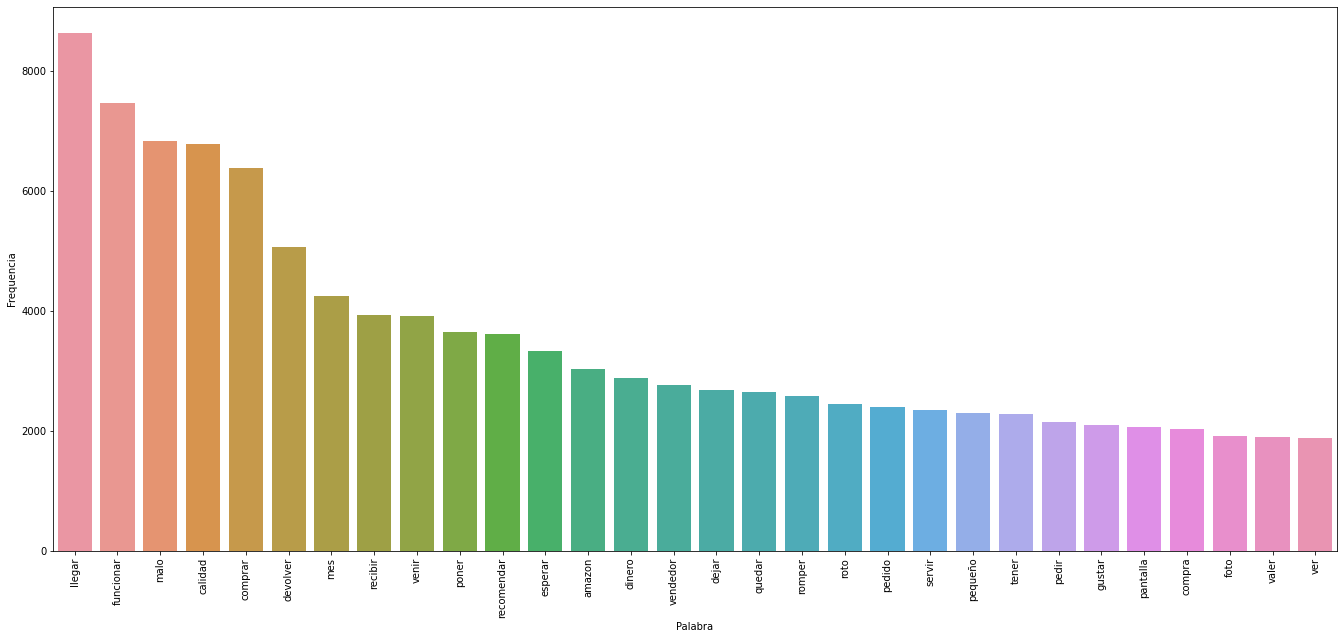

In [ ]:
palabras_mas_frecuentes_por_clase(df_train, "review_title_body_lemm", "stars", 1)

**Clase 5**

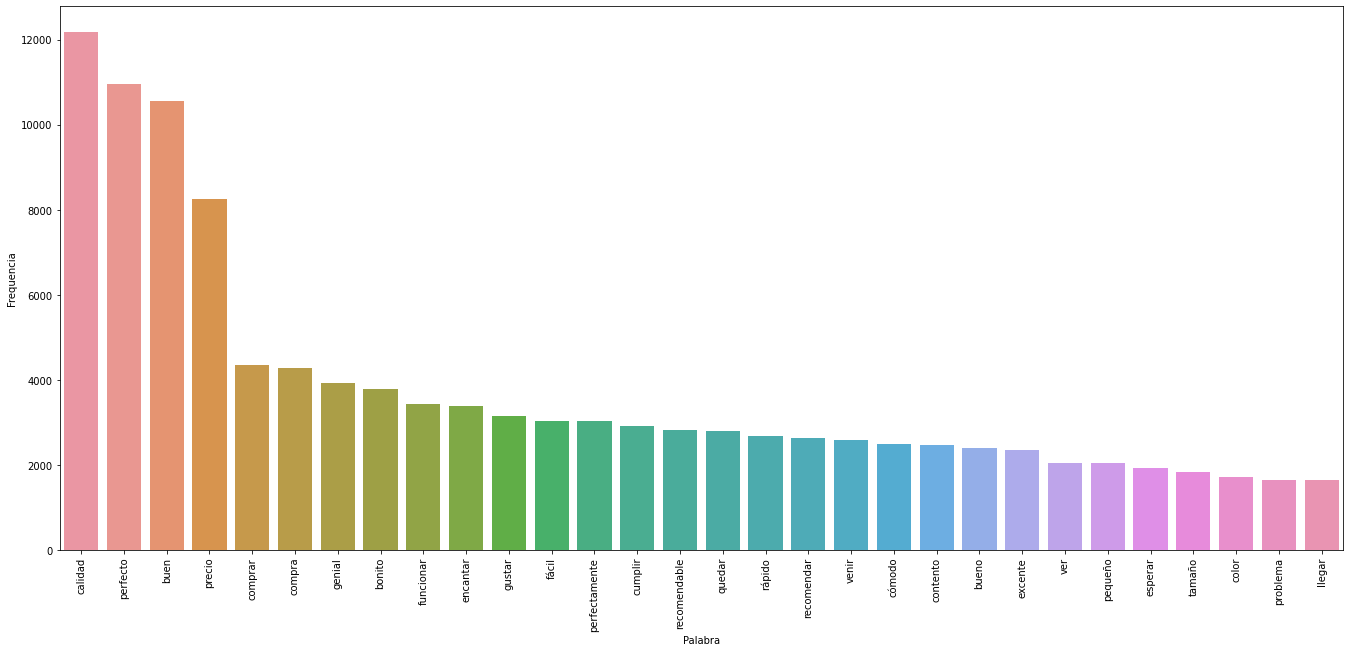

In [ ]:
palabras_mas_frecuentes_por_clase(df_train, "review_title_body_lemm", "stars", 5)

Sistema de recomendacion:

En caso de que las urls no funcionen para cargar los datasets, por favor reemplazarlos por los archivos de este repositorio
https://github.com/MaximilianoAlarcon/Acamica_Proyecto_3_Amazon

In [ ]:
df_train_prueba_sr = pd.read_json("https://amazon-reviews-ml.s3-us-west-2.amazonaws.com/json/train/dataset_es_train.json", lines=True)
df_train_prueba_sr.rename(columns={"reviewer_id": "userID", "product_id": "itemID", "stars": "rating"},inplace=True)
df_train_prueba_sr = df_train_prueba_sr[["userID","itemID","rating"]]
df_train_prueba_sr.head()

,userID,itemID,rating
0,reviewer_es_0999081,product_es_0296024,1
1,reviewer_es_0216771,product_es_0922286,1
2,reviewer_es_0929213,product_es_0474543,1
3,reviewer_es_0224702,product_es_0656090,1
4,reviewer_es_0224827,product_es_0662544,1


In [ ]:
df_test_prueba_sr = pd.read_json("https://amazon-reviews-ml.s3-us-west-2.amazonaws.com/json/test/dataset_es_test.json", lines=True)
df_test_prueba_sr.rename(columns={"reviewer_id": "userID", "product_id": "itemID", "stars": "rating"},inplace=True)
df_test_prueba_sr = df_test_prueba_sr[["userID","itemID","rating"]]
df_test_prueba_sr.head()

,userID,itemID,rating
0,reviewer_es_0580071,product_es_0113523,1
1,reviewer_es_0819733,product_es_0017036,1
2,reviewer_es_0508607,product_es_0138642,1
3,reviewer_es_0491157,product_es_0170887,1
4,reviewer_es_0008745,product_es_0710642,1


In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8MB 290kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617565 sha256=e6e0a6a95a2b33b7bcae4a3813e545e243d5d18d55b561539300d10b7eb4494e
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
df_comleto_prueba_svd = pd.concat([df_train_prueba_sr,df_test_prueba_sr])
df_comleto_prueba_svd.head()

,userID,itemID,rating
0,reviewer_es_0999081,product_es_0296024,1
1,reviewer_es_0216771,product_es_0922286,1
2,reviewer_es_0929213,product_es_0474543,1
3,reviewer_es_0224702,product_es_0656090,1
4,reviewer_es_0224827,product_es_0662544,1


In [ ]:
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV, train_test_split

In [ ]:
reader = Reader()

In [ ]:
data = Dataset.load_from_df(df_comleto_prueba_svd[["userID","itemID","rating"]], reader)

In [ ]:
trainset, testset = train_test_split(data, test_size=.25)

In [ ]:
param_grid = {'n_epochs': [10, 15, 20, 25], 'lr_all': [0.005, 0.01, 0.1, 0.2, 0.3, 0.5, 0.6, 0.8, 0.9],
              'reg_all': [0.1, 0.2, 0.3, 0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

#gs.fit(df_train_prueba_sr)

best_params_svd = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.1}

print("SVD:")
print("="*32)
algo = SVD(lr_all=0.01,n_epochs=25,reg_all=0.1)
print("Best params:")
print(best_params_svd)
algo.fit(trainset)
print("="*32)
predictions = algo.test(testset)
print("Test rmse:",accuracy.rmse(predictions))


# best RMSE score
#print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
#print(gs.best_params['rmse'])

SVD:
Best params:
{'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.1}
RMSE: 1.4055
Test rmse: 1.4055238382038922


Tal parece que el modelo SVD podria ser de utilidad por su bajo nivel de error pero voy a investigar otras alternativas